In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
# import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex
from matplotlib.transforms import ScaledTranslation
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator, AutoLocator

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle, Circle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator

import seaborn as sns

import os
import io
import functools
# from io import StringIO as sio
from io import StringIO
from multiprocessing import Pool

from datetime import datetime
from collections import Counter, defaultdict

In [2]:
from tqdm.notebook import trange, tqdm

In [3]:
import src.baltic as bt

from Bio import Seq
from Bio import SeqIO

import dendropy
# from ete3 import Tree, faces, TreeStyle, TextFace, CircleFace

In [4]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
figure_width_s = 2.25
figure_width_m = 4.75
figure_width_l = 7.25

panel_labels_font_dict = {'fontsize': 10, 'weight': 'bold'}
axis_labels_size = 7
minimum_font_size = 5
minimun_line_weight= .28

plt.rcParams['font.sans-serif'] = ['Arial']  # 用来正常显示中文标签


In [6]:
seg_l = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'NS', 'MP']

# Epidemic outbreak data

In [7]:
# plt.style.available

In [8]:
# epi_data = pd.read_csv('./data/epidemiology-raw-data_202207072051.tsv', sep='\t')
epi_data = pd.read_excel('./data/overview-raw-data_202210212033.xlsx')
# epi_data = pd.read_excel('./data/Fig1AF-emi-H5HPAI-100101-221231.xlsx', sheet_name='Sheet1')
epi_data.Serotype.fillna('', inplace=True)
epi_data.head()

,Event.ID,Disease,Serotype,Region,Subregion,Country,Admin.level.1,Locality,Latitude,Longitude,Diagnosis.source,Diagnosis.status,Animal.type,Species,Observation.date..dd.mm.yyyy.,Report.date..dd.mm.yyyy.,Humans.affected,Human.deaths
0,333073,Influenza - Avian,H5N1 HPAI,Europe,Western Europe,Germany,Schleswig-Holstein,Sylt,54.8800,8.3700,OIE,Confirmed,Domestic,Chicken,07/10/2022,10/10/2022,NaN,NaN
1,333071,Influenza - Avian,H5N1 HPAI,Europe,Western Europe,Germany,Niedersachsen,Wittmund,53.5800,7.7300,OIE,Confirmed,Domestic,Chicken,05/10/2022,10/10/2022,NaN,NaN
2,333355,Influenza - Avian,H5N1 HPAI,Europe,Northern Europe,Faroe Islands,Administrative unit not available,Havnardalur,61.9978,-6.7979,OIE,Confirmed,Domestic,Unspecified Bird,03/10/2022,14/10/2022,NaN,NaN
3,333072,Influenza - Avian,H5N1 HPAI,Europe,Western Europe,Germany,Niedersachsen,Wangerland,53.6700,7.9300,OIE,Confirmed,Domestic,Turkey,02/10/2022,10/10/2022,NaN,NaN
4,333353,Influenza - Avian,H5N1 HPAI,Africa,Eastern Africa,R?union,Arrondissement_souse_le_vent,Saint-Paul,-21.0600,55.3000,OIE,Confirmed,Domestic,Unspecified Bird,02/10/2022,11/10/2022,NaN,NaN


In [9]:
observe_date = pd.to_datetime(epi_data['Observation.date..dd.mm.yyyy.'], dayfirst=True)
report_date = pd.to_datetime(epi_data['Report.date..dd.mm.yyyy.'], dayfirst=True)

epi_data['date'] = observe_date.fillna(report_date)

In [10]:
HPAI_filter = epi_data.Serotype.str.contains('HPAI')
H5_filter = epi_data.Serotype.str.contains('H5')
date_filter = epi_data.date > pd.to_datetime('2016-10-01')

epi_data = epi_data[HPAI_filter & H5_filter & date_filter].copy()

In [11]:
epi_data.Serotype.value_counts()

H5N1 HPAI    7878
H5N8 HPAI    6356
H5N6 HPAI     976
H5N2 HPAI     459
H5 HPAI       394
H5N5 HPAI     202
H5N3 HPAI      16
H5N4 HPAI      14
H5N9 HPAI       3
Name: Serotype, dtype: int64

In [12]:
def parse_serotype(x):
    if isinstance(x, float):
        return 'other'
    if 'H5N8' in x:
        return 'H5N8'
    elif 'H5N1' in x:
        return 'H5N1'
    elif 'H5N6' in x:
        return 'H5N6'
    elif 'H5N2' in x:
        return 'H5N2'
    else:
        return 'other H5Ny'
    
epi_data['subtype'] = epi_data.Serotype.map(parse_serotype)

In [13]:
epi_data2 = epi_data
# there are no 2.3.4.4 H5N1 between 2016/10 and 2020/01
# epi_data2 = epi_data2[~((epi_data2.subtype == 'H5N1') & (epi_data2.date < pd.to_datetime('2020-01-01')))]

epi_data2.head()

,Event.ID,Disease,Serotype,Region,Subregion,Country,Admin.level.1,Locality,Latitude,Longitude,Diagnosis.source,Diagnosis.status,Animal.type,Species,Observation.date..dd.mm.yyyy.,Report.date..dd.mm.yyyy.,Humans.affected,Human.deaths,date,subtype
0,333073,Influenza - Avian,H5N1 HPAI,Europe,Western Europe,Germany,Schleswig-Holstein,Sylt,54.8800,8.3700,OIE,Confirmed,Domestic,Chicken,07/10/2022,10/10/2022,NaN,NaN,2022-10-07,H5N1
1,333071,Influenza - Avian,H5N1 HPAI,Europe,Western Europe,Germany,Niedersachsen,Wittmund,53.5800,7.7300,OIE,Confirmed,Domestic,Chicken,05/10/2022,10/10/2022,NaN,NaN,2022-10-05,H5N1
2,333355,Influenza - Avian,H5N1 HPAI,Europe,Northern Europe,Faroe Islands,Administrative unit not available,Havnardalur,61.9978,-6.7979,OIE,Confirmed,Domestic,Unspecified Bird,03/10/2022,14/10/2022,NaN,NaN,2022-10-03,H5N1
3,333072,Influenza - Avian,H5N1 HPAI,Europe,Western Europe,Germany,Niedersachsen,Wangerland,53.6700,7.9300,OIE,Confirmed,Domestic,Turkey,02/10/2022,10/10/2022,NaN,NaN,2022-10-02,H5N1
4,333353,Influenza - Avian,H5N1 HPAI,Africa,Eastern Africa,R?union,Arrondissement_souse_le_vent,Saint-Paul,-21.0600,55.3000,OIE,Confirmed,Domestic,Unspecified Bird,02/10/2022,11/10/2022,NaN,NaN,2022-10-02,H5N1


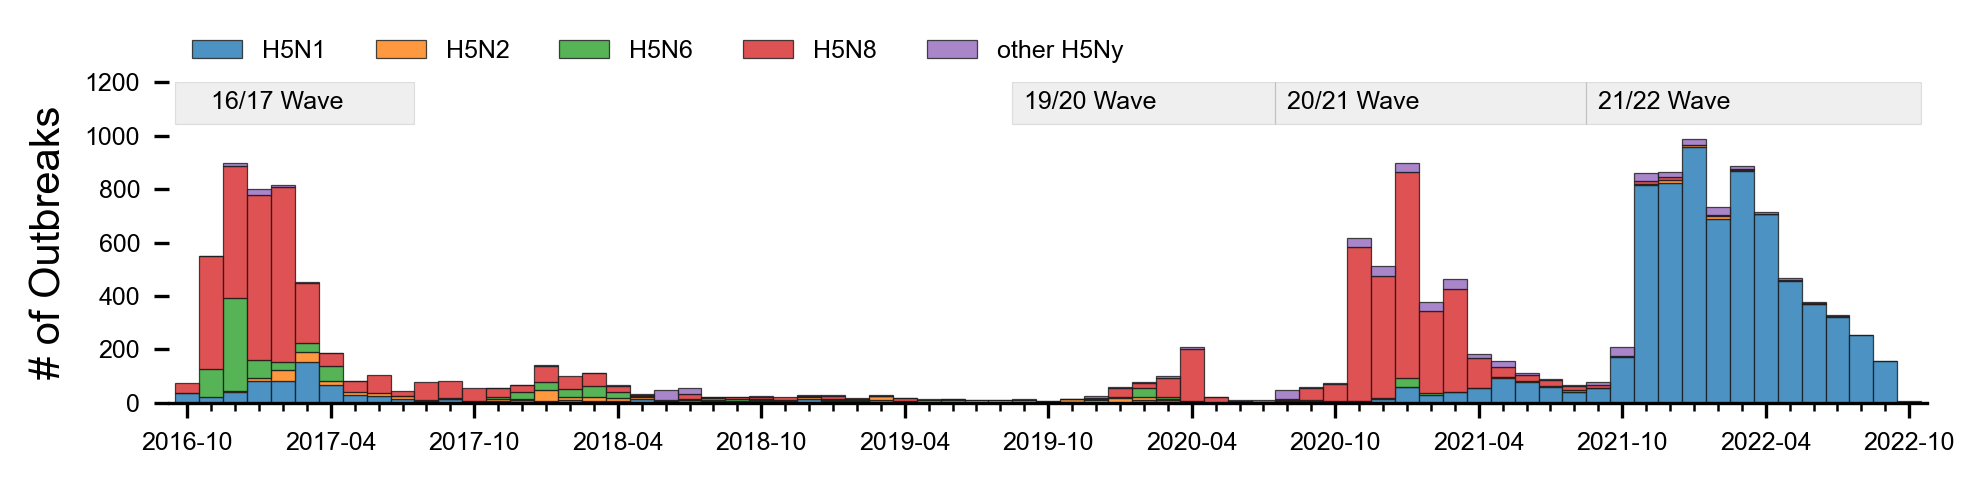

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 1.5), dpi=300, constrained_layout=True)

with mpl.rc_context({'font.family': 'Arial', 'font.size': 6, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
    
    tmp = epi_data2.groupby([epi_data2.date, epi_data2['subtype']]).size().unstack(1).resample('M', kind='period').sum().fillna(0)
    tmp.plot.bar(ax=ax, stacked=True, width=1, edgecolor='.1', alpha=.8, rot=0)
    # format xticks
    ticklabels = tmp.index.strftime("%Y-%m").to_list()
    ax.set(xticks=np.arange(0, tmp.shape[0], 6), xticklabels=ticklabels[::6], xlabel='', ylabel='# of Outbreaks', ylim=[0, 1200])
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=-0.5, xmax= 9.5, ymin=.87, ymax=1, alpha=.1)
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=34.5, xmax=45.5, ymin=.87, ymax=1, alpha=.1)
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=45.5, xmax=58.5, ymin=.87, ymax=1, alpha=.1)
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=58.5, xmax=72.5, ymin=.87, ymax=1, alpha=.1)
    
    ax.text(1, 1100, '16/17 Wave')
    ax.text(35, 1100, '19/20 Wave')
    ax.text(46, 1100, '20/21 Wave')
    ax.text(59, 1100, '21/22 Wave')

    # ax.grid(False)
    ax.spines[['left', 'top', 'right']].set_visible(False)
    ax.legend(title='', fontsize=6, ncol=5, loc='lower left', bbox_to_anchor=(0, 0.99), frameon=False)

plt.show()

**Fig1a Number of outbreaks by subtype**

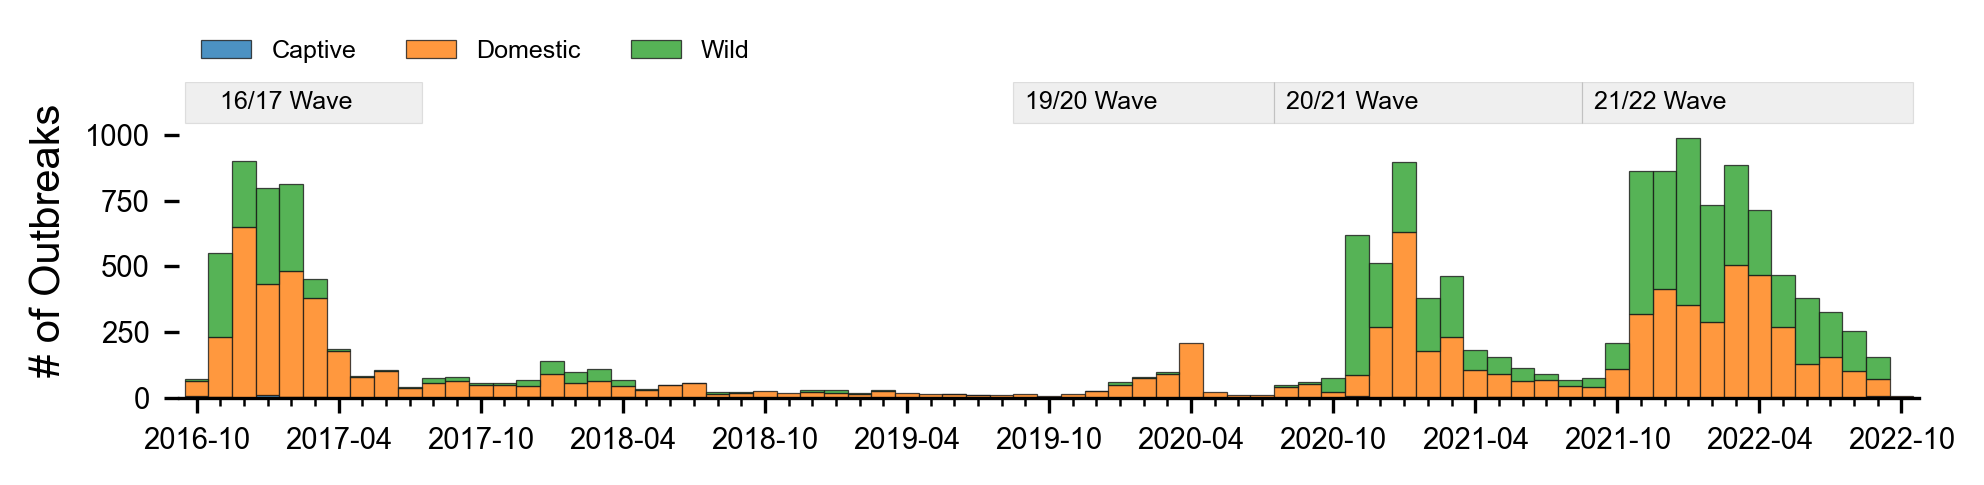

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 1.5), dpi=300, constrained_layout=True)

with mpl.rc_context({'font.family': 'Arial', 'font.size': 6, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
    
    tmp = epi_data2.groupby([epi_data2.date, epi_data2['Animal.type']]).size().unstack(1).resample('M', kind='period').sum().fillna(0)
    tmp.plot.bar(ax=ax, stacked=True, width=1, edgecolor='.1', alpha=.8, rot=0)
    # format xticks
    ticklabels = tmp.index.strftime("%Y-%m").to_list()
    ax.set(xticks=np.arange(0, tmp.shape[0], 6), xticklabels=ticklabels[::6], xlabel='', ylabel='# of Outbreaks', ylim=[0, 1200])
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=-0.5, xmax= 9.5, ymin=.87, ymax=1, alpha=.1)
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=34.5, xmax=45.5, ymin=.87, ymax=1, alpha=.1)
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=45.5, xmax=58.5, ymin=.87, ymax=1, alpha=.1)
    ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=58.5, xmax=72.5, ymin=.87, ymax=1, alpha=.1)

    ax.text(1, 1100, '16/17 Wave')
    ax.text(35, 1100, '19/20 Wave')
    ax.text(46, 1100, '20/21 Wave')
    ax.text(59, 1100, '21/22 Wave')

    # ax.grid(False)
    ax.spines[['left', 'top', 'right']].set_visible(False)

    ax.legend(title='', fontsize=6, ncol=5, loc='lower left', bbox_to_anchor=(0, 0.99), frameon=False)

plt.show();

**Fig1b Number of outbreaks by host**

## burden

In [16]:
# data cite from OIE
domestic_by_wave = np.array([[2174968, 560299, 10514441, 23484971], [1338425, 465275, 5544346, 4891694]])
wild_by_wave = np.array([[7541, 238, 11750, 46218], [6614, 237, 11367, 41013]])

arrays = [['Domestic', 'Domestic', 'Wild', 'Wild'], ['Case', 'Death', 'Case', 'Death']]
idx = pd.MultiIndex.from_arrays(arrays, names=('Host', 'Type'))
burden = pd.DataFrame(np.vstack((domestic_by_wave, wild_by_wave)), index=idx, columns=['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave']).T
burden

Host        Domestic            Wild       
Type            Case    Death   Case  Death
16/17 Wave   2174968  1338425   7541   6614
19/20 Wave    560299   465275    238    237
20/21 Wave  10514441  5544346  11750  11367
21/22 Wave  23484971  4891694  46218  41013

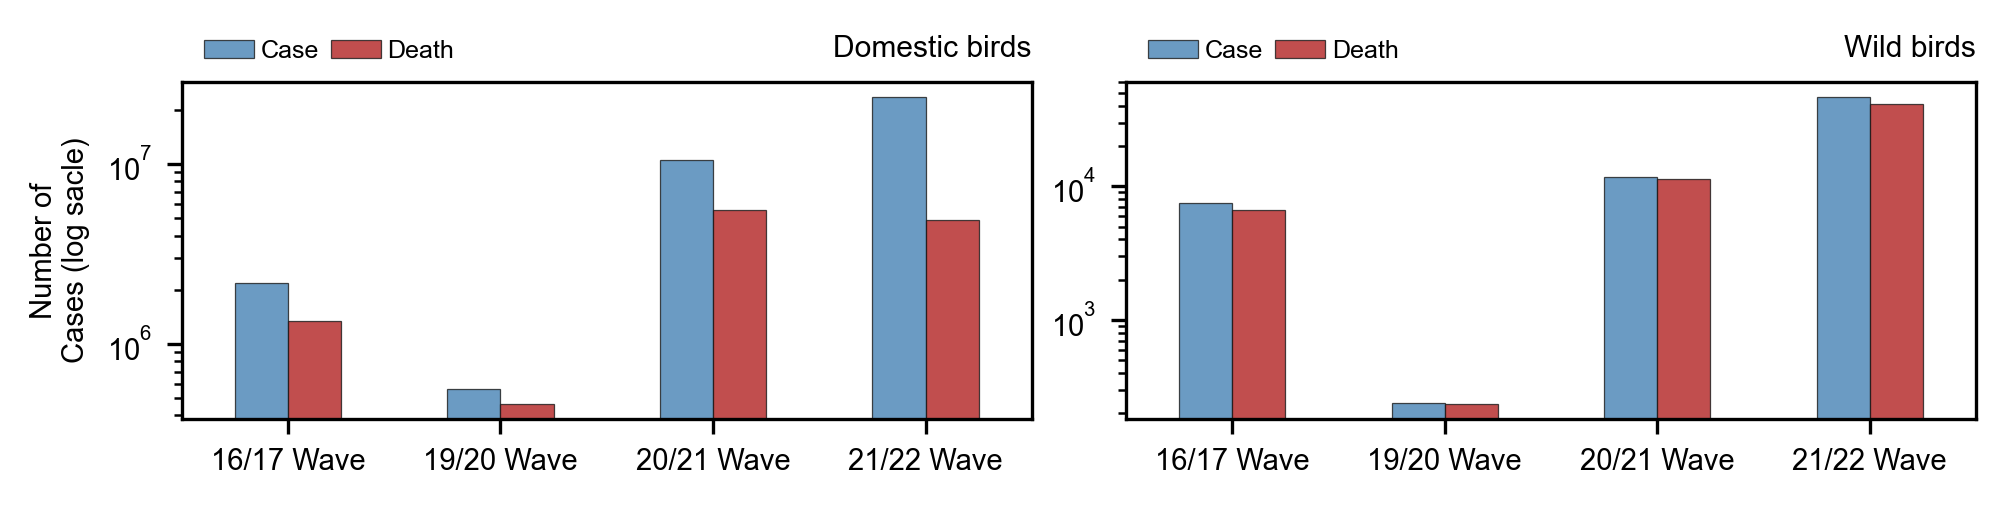

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 1.5), dpi=300, constrained_layout=True)

with mpl.rc_context({'font.family': 'Arial', 'font.size': 6, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):

    tmp = burden
    tmp['Domestic'].plot.bar(ax=ax[0], rot=0, color=['steelblue', 'firebrick'], alpha=.8, edgecolor='.1')
    ax[0].legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.99), fontsize=6, ncols=2, columnspacing=.5, handletextpad=0.25)
    ax[0].set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontsize=7)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Number of\nCases (log sacle)', fontsize=7)
    ax[0].set_title('Domestic birds', loc='right')
    ax[0].tick_params(axis='both', labelsize=7)
    ax[0].grid(False)
    # ax[0].spines[['left', 'top', 'right']].set_visible(False)

    tmp['Wild'].plot.bar(ax=ax[1], rot=0, color=['steelblue', 'firebrick'], alpha=.8, edgecolor='.1')
    ax[1].legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.99), fontsize=6, ncols=2, columnspacing=.5, handletextpad=0.25)
    ax[1].set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontsize=7)
    ax[1].set_yscale('log')
    ax[1].set_title('Wild birds', loc='right')
    ax[1].tick_params(axis='both', labelsize=7)
    ax[1].grid(False)
    # ax[1].spines[['left', 'top', 'right']].set_visible(False)

    fig.get_layout_engine().set(w_pad=2/300, h_pad=2/300, hspace=0.02, wspace=0.02)

plt.show();

In [112]:
burden

Host        Domestic            Wild       
Type            Case    Death   Case  Death
16/17 Wave   2174968  1338425   7541   6614
19/20 Wave    560299   465275    238    237
20/21 Wave  10514441  5544346  11750  11367
21/22 Wave  23484971  4891694  46218  41013

In [148]:
burden2 = burden.stack(0).stack().unstack(0)
burden2

16/17 Wave  19/20 Wave  20/21 Wave  21/22 Wave
Host     Type                                                 
Domestic Case      2174968      560299    10514441    23484971
         Death     1338425      465275     5544346     4891694
Wild     Case         7541         238       11750       46218
         Death        6614         237       11367       41013

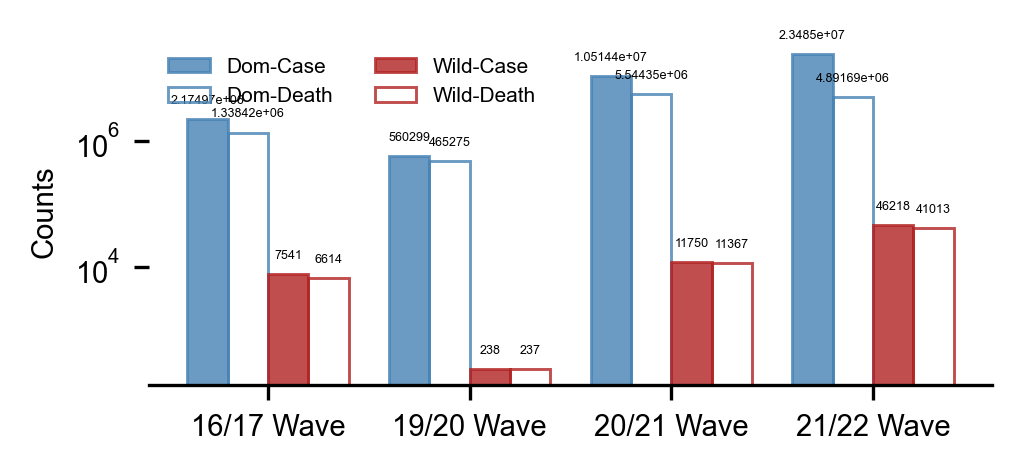

In [273]:
x = np.arange(4)
width = 0.2
multiplier = 0

fig, ax = plt.subplots(figsize=(7.25/2, 1.5), dpi=300)

color_l = ['steelblue','steelblue','firebrick','firebrick']
hatch_l = ['', '', '', '']
linewidth_l = [.7, .7, .7, .7]
fill_l = [True, False, True, False]


for i, (wave, counts) in enumerate(burden2.iterrows()):
    offset = width * multiplier
    rects = ax.bar(x+offset, counts.values, width, label=counts.index[0], 
                   fill=fill_l[i], color=color_l[i], edgecolor=color_l[i], hatch=hatch_l[i], linewidth=linewidth_l[i], alpha=.8)
    ax.bar_label(rects, padding=3, fontsize=3)
    multiplier += 1

ax.set_xticks(ticks=[0.3, 1.3, 2.3, 3.3], labels=['16/17 Wave','19/20 Wave','20/21 Wave','21/22 Wave'], fontsize=7)
plt.setp(ax.get_yticklabels(), fontsize=7)

ax.set_ylabel('Counts', fontsize=7)
ax.set_yscale('log')
ax.spines[['left','top', 'right']].set_visible(False)

ax.legend(['Dom-Case','Dom-Death','Wild-Case','Wild-Death'], frameon=False, ncols=2, fontsize=5)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 1.5), dpi=300, constrained_layout=True)

with mpl.rc_context({'font.family': 'Arial', 'font.size': 6, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):

    tmp = burden
    tmp['Domestic'].plot.bar(ax=ax[0], rot=0, color=['steelblue', 'firebrick'], alpha=.8, edgecolor='.1')
    ax[0].legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.99), fontsize=6, ncols=2, columnspacing=.5, handletextpad=0.25)
    ax[0].set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontsize=7)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Number of\nCases (log sacle)', fontsize=7)
    ax[0].set_title('Domestic birds', loc='right')
    ax[0].tick_params(axis='both', labelsize=7)
    ax[0].grid(False)
    # ax[0].spines[['left', 'top', 'right']].set_visible(False)

    tmp['Wild'].plot.bar(ax=ax[1], rot=0, color=['steelblue', 'firebrick'], alpha=.8, edgecolor='.1')
    ax[1].legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.99), fontsize=6, ncols=2, columnspacing=.5, handletextpad=0.25)
    ax[1].set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontsize=7)
    ax[1].set_yscale('log')
    ax[1].set_title('Wild birds', loc='right')
    ax[1].tick_params(axis='both', labelsize=7)
    ax[1].grid(False)
    # ax[1].spines[['left', 'top', 'right']].set_visible(False)

    fig.get_layout_engine().set(w_pad=2/300, h_pad=2/300, hspace=0.02, wspace=0.02)

plt.show();

In [19]:
human_cases = pd.read_excel('./data/HPAI H5 human.xlsx')
human_cases

,Year,H5N6,H5N1,H5N8
0,2014,3,52,0
1,2015,5,145,0
2,2016,9,10,0
3,2017,2,4,0
4,2018,4,0,0
5,2019,1,1,0
6,2020,5,1,7
7,2021,37,2,0
8,2022,16,6,0


In [233]:
labels

['$\\mathdefault{5}$',
 '$\\mathdefault{10}$',
 '$\\mathdefault{15}$',
 '$\\mathdefault{20}$',
 '$\\mathdefault{25}$',
 '$\\mathdefault{45}$',
 '$\\mathdefault{80}$',
 '$\\mathdefault{185}$']

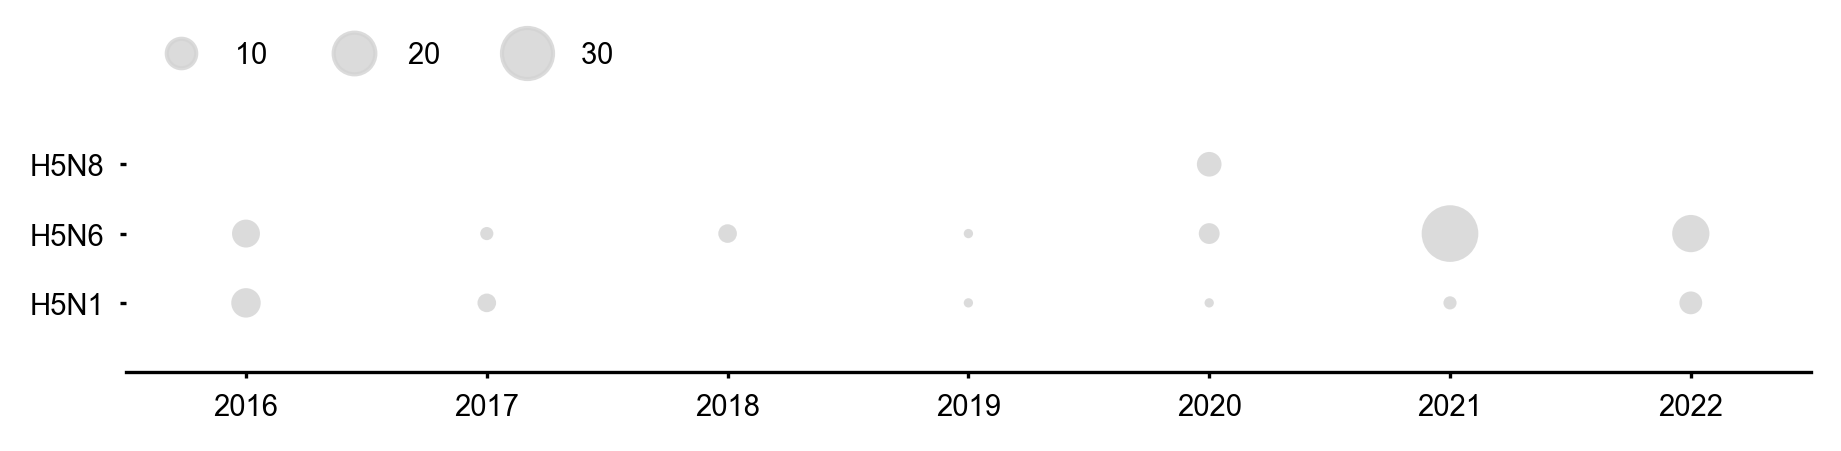

In [253]:
fig, ax = plt.subplots(figsize=(7.25, 1.2), dpi=300)

s1 = ax.scatter(human_cases.Year, [0]*9, s=human_cases.H5N1*5, alpha=.8, c='lightgray', edgecolor='none')
s2 = ax.scatter(human_cases.Year, [1]*9, s=human_cases.H5N6*5, alpha=.8, c='lightgray', edgecolor='none')
s3 = ax.scatter(human_cases.Year, [2]*9, s=human_cases.H5N8*5, alpha=.8, c='lightgray', edgecolor='none')

ax.set_xticks(np.arange(2016, 2023))
ax.set_yticks(ticks=[0, 1, 2], labels=['H5N1','H5N6','H5N8'], fontsize=7)
plt.setp(ax.get_xticklabels(), fontsize=7)

ax.set_ylim(-1, 3)
ax.set_xlim(2015.5, 2022.5)

ax.tick_params(length=1.5, )

handles, labels = s2.legend_elements(prop='sizes', alpha=.8, num=3, func=lambda x: x/5, color='lightgray')
ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 1), ncols=3, fontsize=7, frameon=False)

ax.spines[['left', 'top', 'right']].set_visible(False)


## epidemic range

In [204]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ERROR 1: PROJ: proj_create_from_database: Open of /home/zeng/anaconda3/envs/Bio/share/proj failed


In [205]:
epi_data2 = (gpd.GeoDataFrame(epi_data2, geometry=gpd.points_from_xy(epi_data2.Longitude, epi_data2.Latitude), crs='EPSG:4326')
                .drop(columns=['Observation.date..dd.mm.yyyy.', 'Report.date..dd.mm.yyyy.']))

In [206]:
epi_data_wave1 = epi_data2[epi_data2.date.between('2016-10-01', '2017-08-31')]
country_size_wave1 = epi_data_wave1.sjoin(world, how='left').groupby('name').size()
country_size_wave1.name = 'count'

epi_data_wave2 = epi_data2[epi_data2.date.between('2019-09-01', '2020-08-31')]
country_size_wave2 = epi_data_wave2.sjoin(world, how='left').groupby('name').size()
country_size_wave2.name = 'count'

epi_data_wave3 = epi_data2[epi_data2.date.between('2020-09-01', '2021-08-31')]
country_size_wave3 = epi_data_wave3.sjoin(world, how='left').groupby('name').size()
country_size_wave3.name = 'count'

epi_data_wave4 = epi_data2[epi_data2.date.between('2021-09-01', '2022-10-31')]
country_size_wave4 = epi_data_wave4.sjoin(world, how='left').groupby('name').size()     
country_size_wave4.name = 'count'

world_wave1 = world.set_index('name').join(country_size_wave1)
world_wave2 = world.set_index('name').join(country_size_wave2)
world_wave3 = world.set_index('name').join(country_size_wave3)
world_wave4 = world.set_index('name').join(country_size_wave4)

In [207]:
epi_data_wave1[epi_data_wave1.Country == 'United States of America']

,Event.ID,Disease,Serotype,Region,Subregion,Country,Admin.level.1,Locality,Latitude,Longitude,Diagnosis.source,Diagnosis.status,Animal.type,Species,Humans.affected,Human.deaths,date,subtype,geometry
15008,222080,Influenza - Avian,H5N2 HPAI,Americas,Northern America,United States of America,Montana,Fergus County,47.2583,-109.2793,OIE,Confirmed,Wild,Mallard,NaN,NaN,2016-12-27,H5N2,POINT (-109.27930 47.25830)


In [208]:
country_size_wave1.max(),country_size_wave2.max(),country_size_wave3.max(),country_size_wave4.max()

(486, 272, 845, 929)

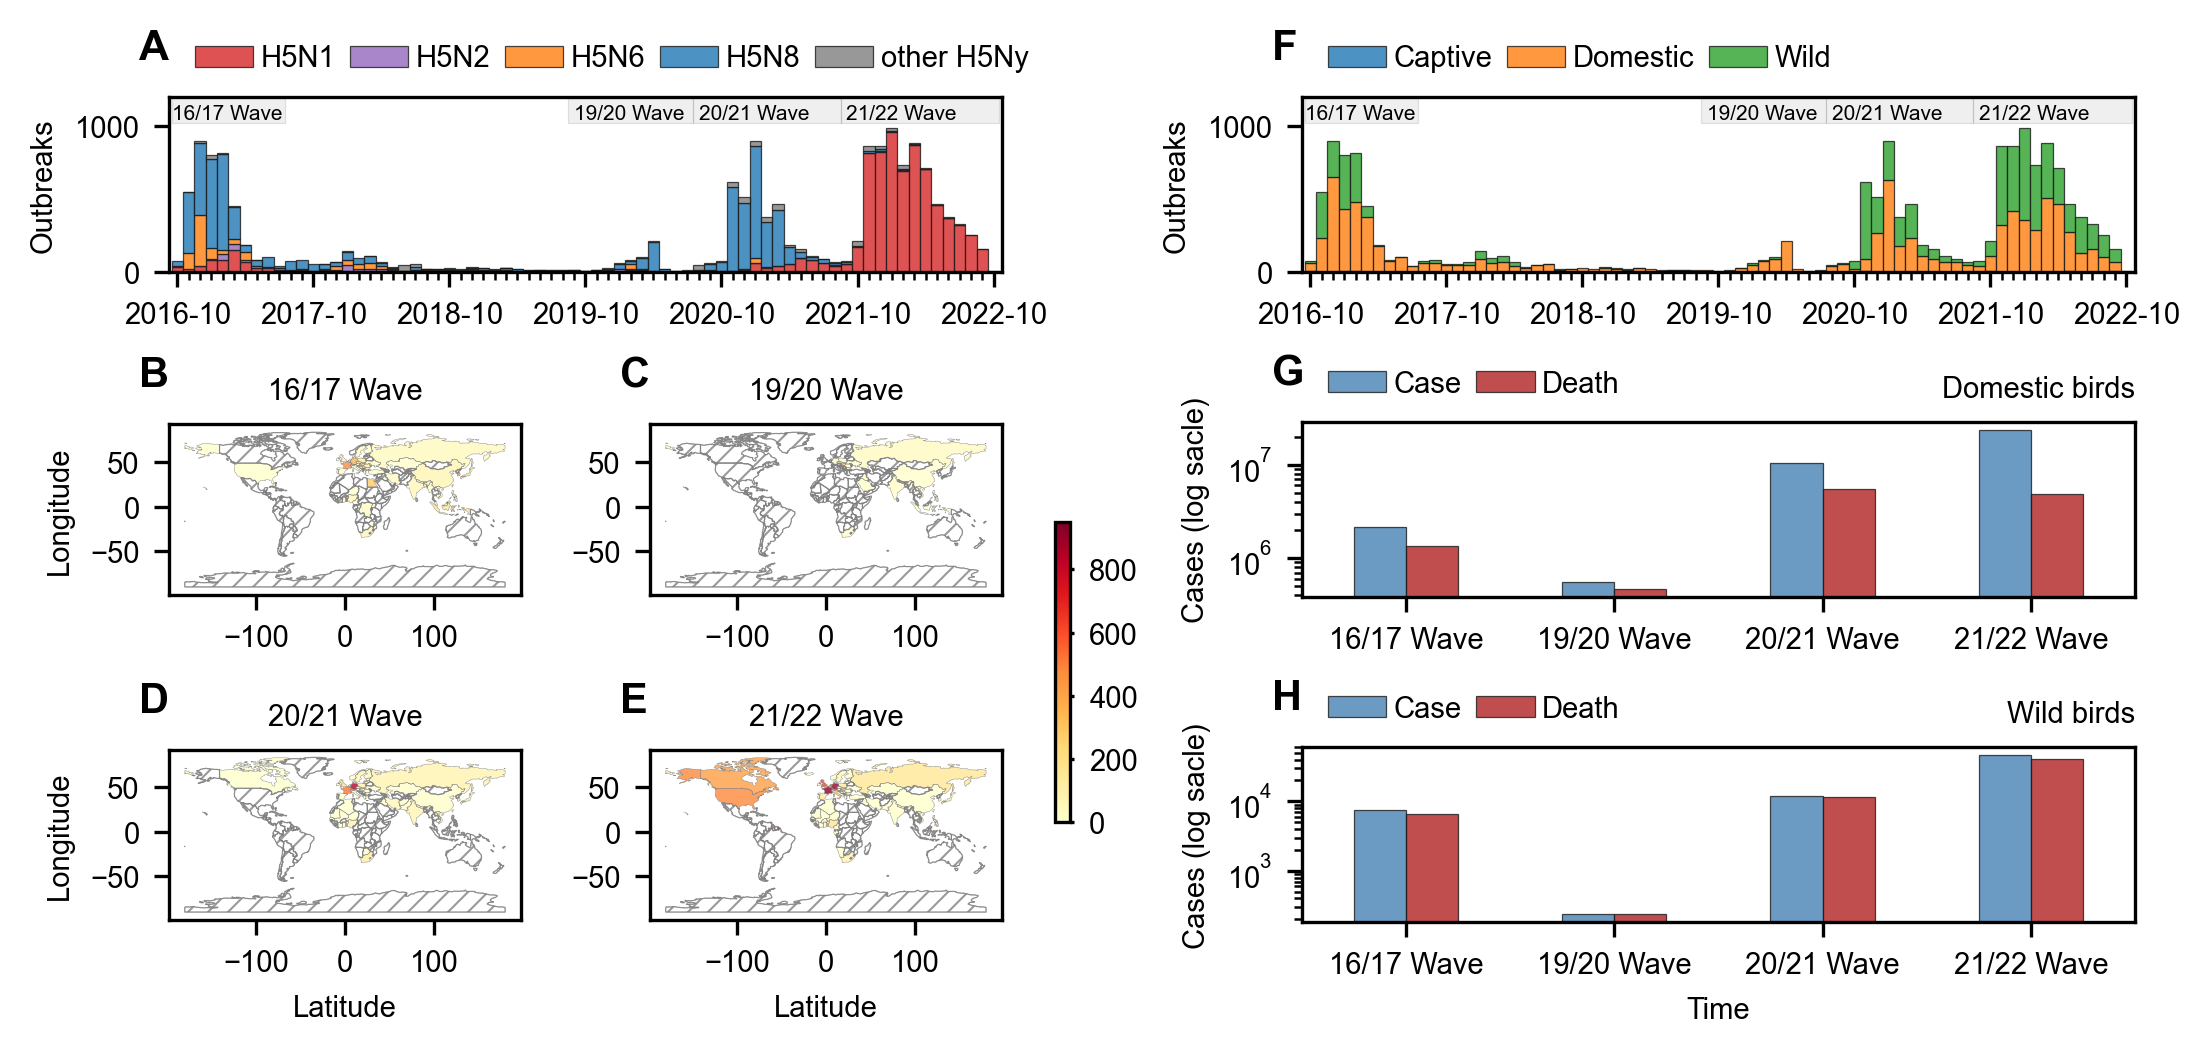

In [38]:
fig = plt.figure(figsize=(7.25, 3.4), dpi=300, layout="constrained")
spec = fig.add_gridspec(3, 4)
trans = ScaledTranslation(-30/300, 30/300, fig.dpi_scale_trans)
with mpl.rc_context({'font.family': 'Arial', 'font.size': 7, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3,}):
    
    # panel A & F
    index_ = 'AF'
    for i, cat in enumerate(['subtype', 'Animal.type']):
        
        ax = fig.add_subplot(spec[0, i*2:(i+1)*2])        
        ax.text(0.0, 1.0, index_[i], transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

        tmp = epi_data2.groupby([epi_data2.date, epi_data2[cat]]).size().unstack(1).resample('M', kind='period').sum().fillna(0)
        if i == 0:
            color = ['C3', 'C4', 'C1', 'C0', 'C7']
        else:
            color = ['C0', 'C1', 'C2']
        tmp.plot.bar(ax=ax, stacked=True, width=1, edgecolor='.1', alpha=.8, rot=0, color=color)

        ticklabels = tmp.index.strftime("%Y-%m").to_list()
        ax.set(xticks=np.arange(0, tmp.shape[0], 12), xticklabels=ticklabels[::12], xlabel='', ylabel='Outbreaks', ylim=[0, 1200])
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=12))
        ax.tick_params(axis='both', which='major', labelsize=7)

        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=-0.5, xmax= 9.5, ymin=.85, ymax=1, alpha=.1)
        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=34.5, xmax=45.5, ymin=.85, ymax=1, alpha=.1)
        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=45.5, xmax=58.5, ymin=.85, ymax=1, alpha=.1)
        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=58.5, xmax=72.5, ymin=.85, ymax=1, alpha=.1)

        ax.text(-.5, 1050, '16/17 Wave', fontsize=5)
        ax.text(35, 1050, '19/20 Wave', fontsize=5)
        ax.text(46, 1050, '20/21 Wave', fontsize=5)
        ax.text(59, 1050, '21/22 Wave', fontsize=5)
        
        ax.legend(title='', fontsize=7, ncols=5, loc='lower left', bbox_to_anchor=(0, 0.99), frameon=False, columnspacing=.5, handletextpad=0.25)
        
    # *****************************************************************************************************************************
    axes = []
    index_ = 'BCDE'
    label_ = ['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'] 
    
    cmap_name = 'YlOrRd'
    for i, world_wave_i in enumerate([world_wave1, world_wave2, world_wave3, world_wave4]):
        ax = fig.add_subplot(spec[i//2 + 1, i%2])
        ax.text(0.0, 1.0, index_[i], transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

        world_wave_i.plot('count', ax=ax, missing_kwds={'color': 'w', 'edgecolor': 'grey', 'hatch': '/////'}, cmap=cmap_name, vmax=950, alpha=.8)
        world_wave_i.boundary.plot(ax=ax, color='grey', lw=.1)
        if i in [0, 2]:
            ax.set_ylabel('Longitude')
        if i in [2, 3]:
            ax.set_xlabel('Latitude')
        ax.set_title(label_[i], fontsize=7)
        ax.tick_params(axis='both', labelsize=7)
        axes.append(ax)

    cmap = cm.get_cmap(cmap_name)
    norm = colors.Normalize(vmin=0, vmax=950)
    im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(im, ax=axes, location='right', orientation='vertical', ticks=np.arange(0, 950, 200), shrink=.6, pad=.01) 
    cbar.ax.tick_params(length=1, labelsize=7)
    
    # *****************************************************************************************************************************
    tmp = burden
    
    # panel G
    ax = fig.add_subplot(spec[1, 2:])
    ax.text(0.0, 1.0, 'G', transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

    tmp['Domestic'].plot.bar(ax=ax, rot=0, color=['steelblue', 'firebrick'], alpha=.8, edgecolor='.1')
    ax.legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.99), fontsize=7, ncols=2, columnspacing=.5, handletextpad=0.25)
    ax.set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontsize=7)
    ax.set_yscale('log')
    ax.set_ylabel('Cases (log sacle)', fontsize=7)
    ax.set_title('Domestic birds', loc='right', fontsize=7)
    
    # panel H
    ax = fig.add_subplot(spec[2, 2:])
    ax.text(0.0, 1.0, 'H', transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')
    
    tmp['Wild'].plot.bar(ax=ax, rot=0, color=['steelblue', 'firebrick'], alpha=.8, edgecolor='.1')
    ax.legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.99), fontsize=7, ncols=2, columnspacing=.5, handletextpad=0.25)
    ax.set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontsize=7)
    ax.set_yscale('log')
    ax.set_ylabel('Cases (log sacle)', fontsize=7)
    ax.set_xlabel('Time', fontsize=7)
    ax.set_title('Wild birds', loc='right', fontsize=7)

    
    # plt.savefig('./results/Fig1.pdf')
    plt.show()
    

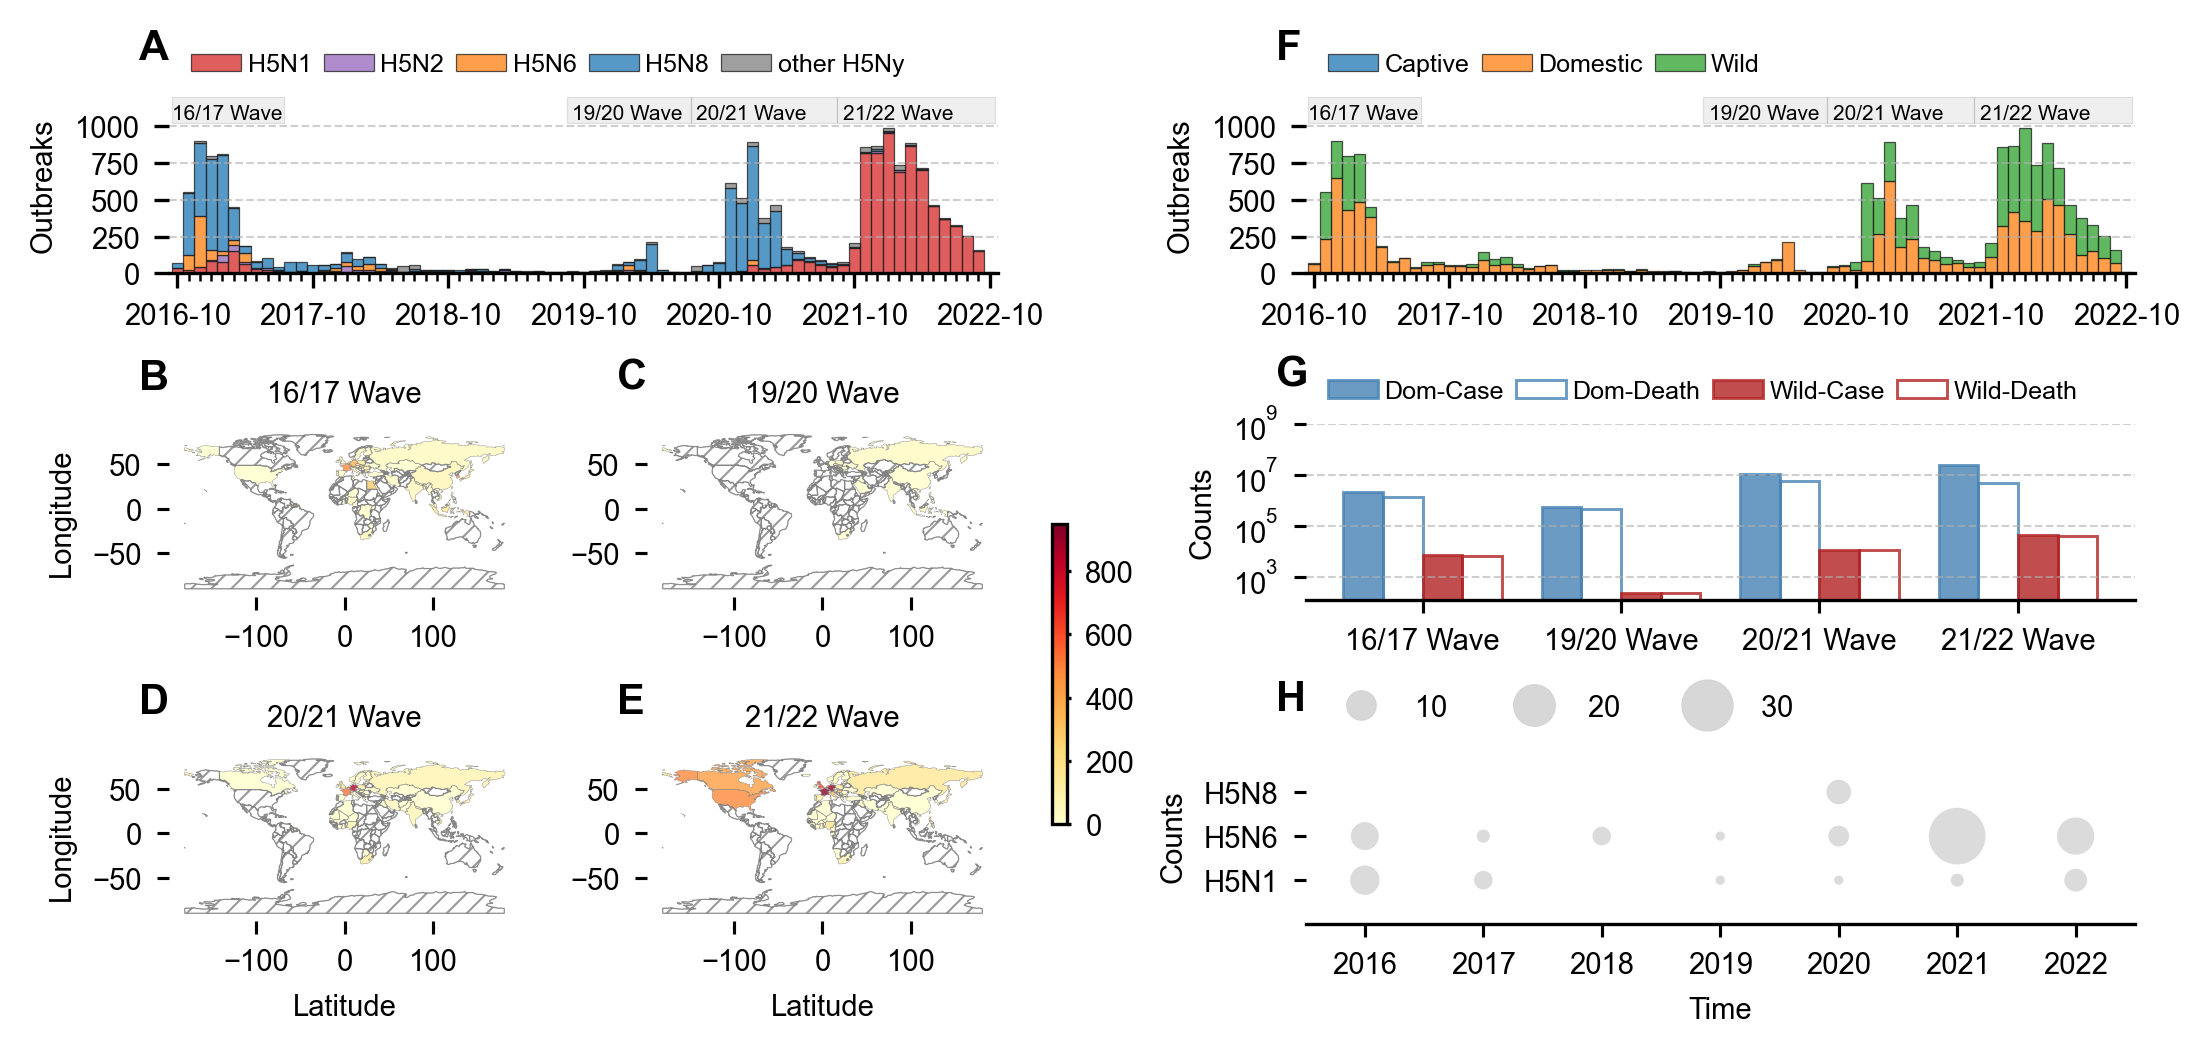

In [388]:
fig = plt.figure(figsize=(7.25, 3.4), dpi=300, layout="constrained")
spec = fig.add_gridspec(3, 4)
trans = ScaledTranslation(-30/300, 30/300, fig.dpi_scale_trans)
with mpl.rc_context({'font.family': 'Arial', 'font.size': 7, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3,}):
    
    # panel A & F
    index_ = 'AF'
    for i, cat in enumerate(['subtype', 'Animal.type']):
        
        ax = fig.add_subplot(spec[0, i*2:(i+1)*2])        
        ax.text(0.0, 1.0, index_[i], transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

        tmp = epi_data2.groupby([epi_data2.date, epi_data2[cat]]).size().unstack(1).resample('M', kind='period').sum().fillna(0)
        if i == 0:
            color = ['C3', 'C4', 'C1', 'C0', 'C7']
        else:
            color = ['C0', 'C1', 'C2']
        tmp.plot.bar(ax=ax, stacked=True, width=1, edgecolor='.1', alpha=.75, rot=0, color=color)
        
        ax.set_yticks([0, 250, 500, 750, 1000])
        ticklabels = tmp.index.strftime("%Y-%m").to_list()
        ax.set(xticks=np.arange(0, tmp.shape[0], 12), xticklabels=ticklabels[::12], xlabel='', ylabel='Outbreaks', ylim=[0, 1200])
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=12))
        ax.tick_params(axis='both', which='major', labelsize=7)

        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=-0.5, xmax= 9.5, ymin=.85, ymax=1, alpha=.1)
        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=34.5, xmax=45.5, ymin=.85, ymax=1, alpha=.1)
        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=45.5, xmax=58.5, ymin=.85, ymax=1, alpha=.1)
        ax.axvspan(edgecolor='k', facecolor='dimgray', xmin=58.5, xmax=72.5, ymin=.85, ymax=1, alpha=.1)

        ax.text(-.5, 1050, '16/17 Wave', fontsize=5)
        ax.text(35, 1050, '19/20 Wave', fontsize=5)
        ax.text(46, 1050, '20/21 Wave', fontsize=5)
        ax.text(59, 1050, '21/22 Wave', fontsize=5)
        
        ax.grid(axis='y', lw=.5, ls='--', alpha=.6)
        ax.spines[['left','top', 'right']].set_visible(False)
        ax.legend(title='', fontsize=6, ncols=5, loc='lower left', bbox_to_anchor=(0, 0.99), frameon=False, columnspacing=.5, handletextpad=0.25)
        
    # *****************************************************************************************************************************
    axes = []
    index_ = 'BCDE'
    label_ = ['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'] 
    
    cmap_name = 'YlOrRd'
    for i, world_wave_i in enumerate([world_wave1, world_wave2, world_wave3, world_wave4]):
        ax = fig.add_subplot(spec[i//2 + 1, i%2])
        ax.text(0.0, 1.0, index_[i], transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

        world_wave_i.plot('count', ax=ax, missing_kwds={'color': 'w', 'edgecolor': 'grey', 'hatch': '/////'}, cmap=cmap_name, vmax=950, alpha=.8)
        world_wave_i.boundary.plot(ax=ax, color='grey', lw=.1)
        if i in [0, 2]:
            ax.set_ylabel('Longitude')
        if i in [2, 3]:
            ax.set_xlabel('Latitude')
        ax.set_title(label_[i], fontsize=7)
        ax.spines[['left','top', 'right', 'bottom']].set_visible(False)
        ax.tick_params(length=3, width=.75, labelsize=7)
        axes.append(ax)
    
    cmap = cm.get_cmap(cmap_name)
    norm = colors.Normalize(vmin=0, vmax=950)
    im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(im, ax=axes, location='right', orientation='vertical', ticks=np.arange(0, 950, 200), shrink=.6, pad=.01) 
    cbar.ax.tick_params(length=1, labelsize=7)
    
    # *****************************************************************************************************************************
   
    x = np.arange(4)
    width = 0.2
    multiplier = 0

    color_l = ['steelblue','steelblue','firebrick','firebrick']
    hatch_l = ['', '', '', '']
    linewidth_l = [.7, .7, .7, .7]
    fill_l = [True, False, True, False]
    
    ax = fig.add_subplot(spec[1, 2:])
    ax.text(0.0, 1.0, 'G', transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')
    
    for i, (wave, counts) in enumerate(burden2.iterrows()):
        offset = width * multiplier
        rects = ax.bar(x+offset, counts.values, width, label=counts.index[0], 
                       fill=fill_l[i], color=color_l[i], edgecolor=color_l[i], hatch=hatch_l[i], linewidth=linewidth_l[i], alpha=.8)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(ticks=[0.3, 1.3, 2.3, 3.3], labels=['16/17 Wave','19/20 Wave','20/21 Wave','21/22 Wave'])
    
    ax.tick_params(length=3, width=.75, labelsize=7)

    ax.set_ylabel('Counts', fontsize=7)
    ax.set_yscale('log')
    ax.set_yticks([1e3, 1e5, 1e7, 1e9])
    ax.grid(axis='y', ls='--', lw=.5, alpha=.6)
    ax.spines[['left','top', 'right']].set_visible(False)

    ax.legend(['Dom-Case','Dom-Death','Wild-Case','Wild-Death'], frameon=False, ncols=4, fontsize=6, loc='lower left', bbox_to_anchor=(0, 0.99), columnspacing=.5, handletextpad=0.25)

    # *****************************************************************************************************************************
    ax = fig.add_subplot(spec[2, 2:])
    ax.text(0.0, 1.0, 'H', transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

    s1 = ax.scatter(human_cases.Year, [0]*9, s=human_cases.H5N1*5, alpha=.8, c='lightgray', edgecolor='none')
    s2 = ax.scatter(human_cases.Year, [1]*9, s=human_cases.H5N6*5, alpha=.8, c='lightgray', edgecolor='none')
    s3 = ax.scatter(human_cases.Year, [2]*9, s=human_cases.H5N8*5, alpha=.8, c='lightgray', edgecolor='none')

    ax.set_xticks(np.arange(2016, 2023))
    ax.set_yticks(ticks=[0, 1, 2], labels=['H5N1','H5N6','H5N8'])

    ax.set_ylim(-1, 3)
    ax.set_xlim(2015.5, 2022.5)

    ax.tick_params(length=3, width=.75, labelsize=7)

    handles, labels = s2.legend_elements(prop='sizes', alpha=.9, num=3, func=lambda x: x/5, color='lightgray')
    ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 1), ncols=3, fontsize=7, frameon=False)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Counts')

    ax.spines[['left', 'top', 'right']].set_visible(False)


    plt.savefig('./results/Fig1.pdf')
    plt.show()
    

**Fig. 1 Epidemiological surveillance of HPAI H5N8 from OIE since 2014**

# Sequence Data

In [281]:
ref_sequences = {'NS': 'atggatcccaacactatgttaagctttcaggtagactgttttctttggtatgtccgcaaacgattcgcagaccaagaactgggtgatgcccctttccttgaccggcttcgccgagatcagaagtctttaagaggaagaggcaccactcttggtctgagcatcgaagcagctactcgtgagggaaagcagatagtgaagcgaattctgaaggaagagtctgatgaggcacttaaaatgactgttgcttcaggtccgtcttcacgctacctaactgatatgactcttgaagaaatgtcaagggactggttcatgctcatgcccaaacggaaagtggcaggtccactttgcatcaaaatggaccaggcaataatggataaaaacatcatattgaaagcaaacttcagtgtaattttcaaccggctggaagctctaatactacttcgagctttcacagaagaaggagcaattgtgggagaaatctcaccgttaccttcttttccaggacatactaatgaggatgtcaaaaatgcaattggggtcctcatcggagggcttgaatggaataataacacagttcgggtctctgaaactctacagagattcgcttggagaaacagtgatgaggatgggagaccttcactccctccaaagtagaaacggaaaatggcgagaacaattgggtcagaagtttgaagaaataagatggctgattgaagaaatgcgacatagactgaagattacagaaaatagcttcgaacagataacgtttatgcaagccttacaactattgcttgaagtggagcaagagataagaactttctcgtttcagcttatttga', 
'NP': 'atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactggtggggagcgccagaatgccactgagattagagcatcggttggaagaatggttggtggaattgggaggttctacatacagatgtgcactgagctcaaactcagcgactatgaaggaagactgatccagaacagcataacaatagagagaatggttctctccgcatttgatgaaaggagaaacaaatatctggaagaacatcccagtgcggggaaagacccgaagaaaacaggaggtccaatttatcgaaggagagatgggaaatgggtgagagagctgatcctgtatgacaaagaggagatcaggaggatctggcgtcaagcgaataatggagaagacgcaactgctggtctcactcacctgatgatctggcattccaatctaaatgatgccacataccagaggacaagagctctcgtgcgtaccggtatggaccccaggatgtgctccctcatgcaagggtcaactctcccaaggaggtctggagctgctggtgcagcagtgaagggagttggaacgatggtgatggaactaattcggatgataaagcgaggagttaatgatcgaaacttctggagaggcgagaatggacggaggacaaggattgcatttgagagaatgtgcaatattctcaaagggaaattccaaacagcagcacaaagagcaatgatggatcaagtgcgtgaaagcaggaatcctggcaatgctgaaattgaagatctcatttttctggcgcggtctgctctcattctgagaggatcagtggcccataagtcctgcttgcccgcttgtgtatacgggctcgctgtagtcagtggatacgactttgagagagaagggtactctctagttggaatagaccctttccgactgcttcaaaacagccaggtctttagtctcattagaccaaatgagaatccagcacacaagagtcaattggtgtggatggcatgtcattctgcagcattcgaggatctgagagtctcaagtttcatcagaggaacaagagtagtcccaagaggacaactatccactagaggagttcaaattgcttcaaatgaaaacatagaaacaatggactccagcactcttgaactgagaagcagatattgggctataagaaccaggagtggaggaaacaccaaccaacagagagcatctgcaggacaaatcagtgtacagcccactttctcggtacagagaaaccttcccttcgaaagagcgaccattatggcggcattcacagggaacactgaaggcagaacgtccgacatgaggactgaaatcataagaatgatggaaagtgccagaccagaagatgtgtctttccaggggcggggagtcttcgagctcncggacgaaaaggcaacgaacccgatcgtgccttcctttgacatgagtaatgaaggatcttatttcttcggagacaatgcagaggagtatgacaattaa', 
'PB2': 'atggagagaataaaagaactaagagatttgatgtcgcagtctcgcactcgcgagatactaacaaaaaccactgtggaccatatggccataataaagaaatacacatcaggaagacaggagaagaaccctgccctcaggatgaaatggatgatggcaatgaaatatcctattacagctgacaaaagaataatggagataatccctgaaaggaatgagcaaggtcagactctctggagcaaaacaaatgatgctggatcagacagagtgatggtctcacctctggctgtgacatggtggaatagaaatgggccaacaacaagtacagtacactacccaaaagtctacaaaacctactttgaaaaggtagaaaggttgaaacatggaacctttggtcctgttcactttcgaaatcaggttaagatacgccgcagggttgacataaacccgggccatgcagatctcagtgccacagaagcacaggatgtcatcatggaggttgttttcccaaatgaagttggagccaggatcttgacatcagaatcacaattaacaataacaagggaaaagaaggaggaacttcaggattgcaagattgctcctttgatggtggcatacatgttggaaagagaactggttcgcaagaccagatttttaccagtagctggaggaacaagcagcgtatacatcgaggtattgcatttgactcaagggacctgctgggaacaaatgtacacaccaggaggggaggtgagaaatgatgatgttgatcagagtttgatcattgctgctagaaatatagttaggagggcaacagtatcagcagacccattggcttcgcttttggaaatgtgccacagtacacaaattggtggagtaaggatggtggacattcttaggcagaacccaacagaggagcaagctgtggatatatgcaaagcagcaatgggtttaagaatcagttcatccttcagctttggaggtttcactttcaaaaggacaagtgggtcgtctgtcaaaagagaagaagaaatactcactggcaacctccaaacactgaaagtaagaatacatgaaggatatgaggaattcacaatggttgggcgaagagctacagccattttgaggaaagcaaccaggagactgatccaattaatagtgagtggaagagacgagcagtcaatcgctgaagcaatcatagtggcaatggttttctcacaggaggattgcatgataaaagcagtacgaggtgatttgaattttgtcaacagagcgaatcagcggctaaatcctatgcatcaacttctgaggcatttccaaaaggatgcaaaagtgctgtttcaaaactgggggattgaaccaattgacaatgtaatggggatgatcgggatactgcctgacatgacccccagcacagagatgtcactgagaggagtgagagtcagcaaaatgggagtggatgaatattccagtactgagagagtggtcgtgagcattgatcgcttcttgagagtccgagatcagaggggaaatgtgcttctgtcccctgaggaagttagtgaaacacatggaacagagaaactgacgataacgtattcatcgtctatgatgtgggaaatcaatggtccggaatccgtgctagtcaacacatatcaatggatcattagaaattgggaaactgtgaagattcagtggtcccaggaccctacgatgttgtacaataagatggaatttgagcccttccaatccttggtgcccaaggctgctagaggccagtatagtgggtttgtgaggacattattccaacagatgcgtgatgtgttggggacatttgacactgtccaaataataaagctcctaccatttgcagcagccccaccggaacagagtaggatgcaattttcctctctgactgtgaacgtaagaggttcaggaatgagaatacttgtgaggggcaactcccctgtgttcaactataataaggccaccaagagactcacagttcttggaaaggatgcaggcgccttgacagaatatccagatgagggaacagcaggagtggagtctgcagtattaagaggatttctaattctgggcaaagaggacaaaagatatggaccagcattgagcatcaacgaattgagcaatcttgcgaaaggggaaaaggctaatgtgttgataggacaaggagacgtggtgttggtaatgaaacggaaacgggactctagcatacttactgacagccagacagcgaccaaaagaattcggatggccatcaattag',
'PA': 'atggaagactttgtgcgacaatgcttcaatccaatgattgtcgagcttgcggaaaaggcaatgaaagaatatggggaagatcctaagatcgaaacaaacaagtttgccgcaatatgtacacacttagaagtctgcttcatgtattcggatttccatttcattgatgaacgaggcgaatcaataatcgtagaatctggcgacccgaatgcattattgaagcaccgatttgagataattgaagggagagaccgaacaatggcctggacagtggtgaatagtatatgcaacactacaggagtcgaaaagcccaagttccttcctgatttgtatgactacagagaaaaccgattcattgaaattggagtaacgcgaagggaagttcacatatactatcttgaaaaagccaacaagataaaatcagagaaaacacacattcacatattctcattcactggggaggaaatggccaccaaggccgattacactcttgatgaagagagcagagcaagaataaaaaccaggctattcactataagacaagagatggccaataggggtctatgggattcctttcgtcagtccgagagaggcgaagagacaattgaagaaagatttgaaatcacaggaaccatgcgcaggcttgctgaccaaagtctcccaccgaacttcgccagccttgaaaactttagagcctatgtggatggatttgaaccgaacggctgcattgagggcaagctttctcaaatgtcaaaagaagtgaatgccagaattgagccatttctgaagacgacaccacgccctctcagattacctgatggacctccctgttcccagcggtcgaagttcttgctaatggatgcccttaaattgagcattgaagacccgagccatgagggggagggtataccgctgtacgatgcaaccaaatgcatgaagacattttttggctggaaggagcccaacatcgtgaaaccacatgaaaagggcataaaccctaattacctcctggcttggaagcaggtgctatcagaactccatgatattgaaaacgaggagaaaatcccaaaaacaaagaacatgaagaagacgagccaactgaagtgggcacttggtgaaaacatggcaccagagaaagtggactttgaggactgtaaagatgttagcgatctaagacagtacgacagtgacgaaccagagtctagatcactagcaagttggatccagagtgaatttaacaaggcttgcgaactgacagattcgagttggattgaacttgatgaaataggggaagacgttgctccaattgaacacattgcgagtatgaggaggaactatttcacagcggaagtatcccattgcagggctacagaatacataatgaaaggagtatacataaacacagctttattgaatgcatcctgtgcagccatggatgacttccaactgattccaatgataagcaaatgcagaaccaaagaagggagacggaagacaaatctgtatggcttcattataaaaggaagatcccatttgaggaatgacaccgatgtggtaaactttgtgagcatggaattctctctcactgacccaaggctggagccacacaaatgggaaaagtactgtgtgcttgaggtaggagacatgctcctacggactgcaataggccaagtgtcaaggcccatgttcctgtatgtgagaaccaatgggacttctaagatcaaaatgaaatggggtatggagatgaggcgatgccttcttcaatcccttcaacaaattgagagcatgattgaagccgagtcttctgtcaaagaaaaagacatgaccaaggaattctttgaaaacagatcagaaacatggccaattggagagtcacccaaaggagtggaggaaggctccattgggaaggtgtgcagaacattgctagcaaagtctgtgttcaacagcctatatgcatctccacaactcgaggggttttcagctgaatcaagaaagttgcttctcattgttcaggcacttagggacaacctggaacctggaaccttcgatcttggggggctatatgaagcaattgaggagtgcctgattaacgatccctgggttttgcttaatgcgtcttggttcaactccttcctcacacatgcactgaaatag',
'MP': 'atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcccgtcaggccccctcaaagccgagatcgcgcagagacttgaagatgtctttgcagggaagaacaccgatcttgaggctctcatggaatggctaaagacaagaccaatcctgtcacctctgactaaggggattttgggatttgtgttcacgctcaccgtgcccagtgagcgaggactgcagcgtagacgctttgtccaaaatgctctaaatggaaatggagacccaaacaacatggacagggcagtcaaactgtacaggaaattgaagagagagataacattccatggggctaaagaagttgcactcagttactcaaccggtgcacttgccagttgtatgggtctcatatacaacaggatggggacggtgaccgcagaagtggcattgggcctagtgtgtgccacctgtgagcagattgctgattcacagcatcggtctcacagacagatagcaaccaccaccaacccactaatcagacatgaaaacagaatggtgttggccagtactacagctaaggctatggagcagatggctggatcgagtgagcaagcagcggaagccatggaggttgctagtcaggctaggcagatggtgcaggcgatgaggaccattggaactcatcctagctccagtgccggtctgagagatgatctccttgaaaatttgcaggcctaccaaaaacggatgggagtgcaactgcagcgattcaagtgatcctctcgttattgccgcaagtatcattgggatcttgcacttgatattgtggattcttgatcgccttttcttcaaatgcgtttatcgtcgccttaaatacggtttgaaaagagggccttctacggaaggagtacctgagtccatgagggaagagtaccggcaggaacagcagagtgctgtggatgttgacgatggtcattttgtcaacatagagctggagtaa',
'NA': 'atgaatccaaatcagaaaatagcgaccattggctccatctcattgggactagttgtattcaatgttctactgcatgccttgagcatcatattaatggtgttagccctggggaaaagtgaaaacaatggaatctgcaagggaactatagtaagggaatataatgaaacagttaggatagagaaagtgacccagtggtacaacactagtgtagtcgaatatgtaccgcattggaacgagggcgcttatataaacaacaccgaaccaatatgtgatgtcaagggctttgcacctttttccaaggacaacggaataagaattggctccagaggacatatttttgtcataagggagcctttcgtctcttgttcacctgtagagtgcagaactttcttcctcactcagggagctctactcaatgacaaacactcaaatggaacagtgaaggataggagcccattcagaactctcatgagtgtcgaagtgggtcaatcacccaatgtgtatcaagcaaggtttgaagctgtagcatggtcagcaacagcctgtcatgatggtaagaaatggatgacgattggtgtgacagggccagattcgaaagcaatagcagtagtccattacggaggagtgcctactgatattgttaactcctgggcaggagacatattacggactcaggagtcatcttgtacttgcattcaaggtaattgttattgggtaatgactgacggtccatccaatagacaggcgcagtatagaatatacaaagcaaatcaaggcaaaataattgaccaagcagatgtcagctttagtggagggcatattgaggaatgctcttgttatccaaatgatggtaaagtggaatgcgtgtgtagagacaactggatgggaactaacaggcctgtgctagttatctcgcctgacctctcttacagggttgggtatttatgtgcgggattgcccagtgacactccaagaggggaagatgcccaatttgtcggttcgtgcactagtcccatgggaaatcaggggtatggcgtaaaaggtttcgggtttcgacagggaactgatgtgtggatggggcggacaattagtcgaacctccaggtcagggtttgaaataataaggataaagaatggttggacgcagacaagcaaagaacagattagaaggcaggtggttgttgataatttgaattggtcgggatacagtgggtctttcactttaccagtagaattgtctgggagggaatgtttagtcccctgtttttgggtcgaaatgatcagaggcaggccagaagaaagaacaatctggacctctagtagctccattgtaatgtgtggagttgatcatgaaattgccgattggtcatggcacgatggagctattcttccctttgacatcgatgggatgtaa',
'PB1': 'atggatgtcaatccgactttacttttcttaaaagtgccagcgcaaaatgctataagtactacattcccttacactggagatcctccatacagccatggaacaggaacagggtataccatggacacagtaaacagaacacatcaatactcagaaaagggaaaatggacaacaaacacagaaaccggagcaccccaactcaacccaattgatggaccattaccagaggacaatgagccaagcggatatgcacaaactgattgcgtgttggaagcaatggctttccttgaagaatcccacccagggatatttgaaaactcttgtcttgaagcgatggaaatcgttcagcaaacaagagtggacaaactaacccaaggtcgccagacttatgactggacactgaacagaaaccaaccagctgcaacctctttggccaacactatagaggtgttcagatcgaatggtctgacagccaatgaatcagggagactgatagattttctcagggatgtgatggaatcaatggataaagaagagatggaagtaacaacacatttccagagaaaaagaagagtgagggacaacatgactaagaagatggtcacacaaagaacaatagggaagaagaagcagaggctgaacaagaggagttacttaataagagcactgacattgaatacaatgaccaaagatgcagaaagaggcaagttgaagagacgggcaattgcaacacccgggatgcagattagaggattcgtgtacttcgttgaaacactagcgaggagcatctgtgagaaactagagcaatctgggctccctgttggagggaatgagaagaaggctaaattggcaaatgttgtgagaaaaatgatgactaactcacaagatacagagctctcctttacaattactggggacaacaccaaatggaatgagaatcaaaaccctcggatgtttttggcaatgataacatatatcacaagaaaccaacctgaatggtttagaaatgtcttaagcattgcccctataatgttctcaaacaaaatggcgagattagggaaaggatacatgtttgaaagtaagagcatgaagctaagaacacaaataccagcagagatgcttacaaatatcgatctgaagtatttcaacgaaccaacgagaaagaaaatcgagaaaataagacctctgctgattgatggcacggcctcattgagtcctgggatgatgatgggcatgttcaatatgctgagcacagtattaggggtctcaatcctgaatctcgggcaaaaaaggtacaccaaaaccacatactggtgggatggacttcaatcctctgatgatttcgctctcatagtgaatgcaccgaatcatgaggggatacaagcaggagtggatagattctataggacctgcaaactggttgggatcaacatgagcaaaaagaagtcttacataaaccgaacaggaacatttgagttcacaagttttttctatcgctatggatttgtagctaacttcagtatggaattacccagctttggagtgtctggaatcaatgaatcagctgacatgagcattggagttacagtgataaaaaacaatatgataaacaatgatcttggaccagcaacagctcaaatggctcttcagttattcatcaaagattataggtacacataccgatgccacaggggtgatacacaaattcaaacgaggagatcattcgagctgaagaagctgtgggagcagacccgttcaaaggcagggctgttgatatcagacggggggccaaacctatacaacattcggaatctccacatcccagaggtctgcttgaagtgggagctgatggatgaagactaccaaggcaggctgtgcaatcccctgaatccatttgtcagtcataaagagattgagtccgtaaacaatgctgtagtgatgcccgcccatggcccggccaagagcatggaatatgatgctgttgcgaccacacactcgtggattcctaagaggaaccgttccattctcaataccagccaaaggggaattcttgaggatgagcagatgtaccaaaagtgctgtagtctattcgagaaattcttccccagcagttcatacaggaggccagttggaatttccagcatggtggaggccatggtgtctagggcccgaattgatgcacgcatcgacttcgaatctggaaggattaagaaagaagagtttgctgagatcatgaagatctgttccaccattgaagagctcagacggcaaaaatag',
'HA': 'atggagaacatagtacttcttcttgcaatagttggccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagcaagttgacacgataatggaaaagaacgtcactgttacacatgcccaagacatactggaaaaaacacacaacgggaagctctgtgatctaaatggggtgaagcctctgattttaaaggattgtagtgtagctggatggctcctcggaaacccaatgtgcgacgaattcatcagagtgccggaatggtcctacatagtggagagggctaatccagctaatgacctctgttacccagggagcctcaatgactatgaagaactgaaacacctgttgagcagaataaatcattttgagaagattctgatcatccccaagagttcctggccaaaccatgaaacatcactaggggtgagcgcagcttgtccataccagggagcgccctcctttttcagaaatgtggtgtggcttatcaaaaagaacgatgcatacccaacaataaagataagctacaataataccaatcgggaagatctcttgatactgtgggggattcaccattccaacaatgcagaagagcagataaatctctataaaaacccaaccacctacatttcagttggaacatcaactttaaaccagaggttggtaccaaaaatagctactagatcccaagtaaacgggcaacgtggaagaatggacttcttctggacaattttaaaaccggatgatgcaatccatttcgagagtaatggaaatttcattgctccagaatatgcatacaaaattgtcaagaaaggggactcaacaattatgaaaagtggagtggaatatggccactgcaacaccaaatgtcaaaccccagtaggagcgataaattctagtatgccattccacaacatacatcctctcaccattggggaatgccccaaatacgtgaaatcaaacaagttggtccttgcgactgggctcagaaatagtcctctaagagaaaagagaagaaaaagaggcctgtttggggcgatagcagggtttatagagggaggatggcagggaatggttgatggttggtatgggtaccaccatagcaatgagcaggggagtgggtacgctgcagacaaagaatccacccaaaaggcaatagatggagttaccaataaggtcaactcaatcattgacaaaatgaacactcaatttgaggcagttggaagggagtttaataacttagaaaggaggatagagaatttgaacaagaaaatggaagacggattcctagatgtctggacctataatgctgaacttctagttctcatggaaaacgagaggactctagatttccatgattcaaatgtcaagaacctttacgacaaagtcagactacagcttagggataatgcaaaggagctgggtaacggctgtttcgaattctatcacaagtgcgataatgaatgtatggaaagtgtgagaaatgggacgtatgactaccctcagtattcagaagaagcaagattaaaaagagaagaaataagcggagtgaaattagaatcaataggaacttaccagatactgtcaatttattcaacagcggcgagttccctagcactggcaatcatgatggctggtctatctttatggatgtgctccaatgggtcgttacagtgcagaatttgcatttaa'
}

## sequence metainfo 

In [282]:
original_data_dir = './data/'

all_h5_info_file = 'gisaid_epiflu_isolates.xls'
all_h5_seqs_file = 'gisaid_epiflu_sequence.fasta'

In [283]:
cols = ['Isolate_Id', 'Isolate_Name', 'Subtype', 'Location', 'Host', 'Domestic_Status', 'Collection_Date', 'Submission_Date', 'Submitting_Lab', 'Authors']

In [284]:
all_h5_info = pd.read_excel(original_data_dir+all_h5_info_file)
ts_m = pd.to_datetime(all_h5_info.Collection_Date)

In [285]:
all_h5_info[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13866 entries, 0 to 13865
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Id       13866 non-null  object
 1   Isolate_Name     13866 non-null  object
 2   Subtype          13866 non-null  object
 3   Location         13866 non-null  object
 4   Host             13866 non-null  object
 5   Domestic_Status  2147 non-null   object
 6   Collection_Date  13866 non-null  object
 7   Submission_Date  13866 non-null  object
 8   Submitting_Lab   8090 non-null   object
 9   Authors          9955 non-null   object
dtypes: object(10)
memory usage: 1.1+ MB


In [286]:
all_h5_info.loc[ts_m>pd.Timestamp('2016-10-01'), cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6966 entries, 2 to 13865
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Id       6966 non-null   object
 1   Isolate_Name     6966 non-null   object
 2   Subtype          6966 non-null   object
 3   Location         6966 non-null   object
 4   Host             6966 non-null   object
 5   Domestic_Status  1551 non-null   object
 6   Collection_Date  6966 non-null   object
 7   Submission_Date  6966 non-null   object
 8   Submitting_Lab   4912 non-null   object
 9   Authors          5046 non-null   object
dtypes: object(10)
memory usage: 598.6+ KB


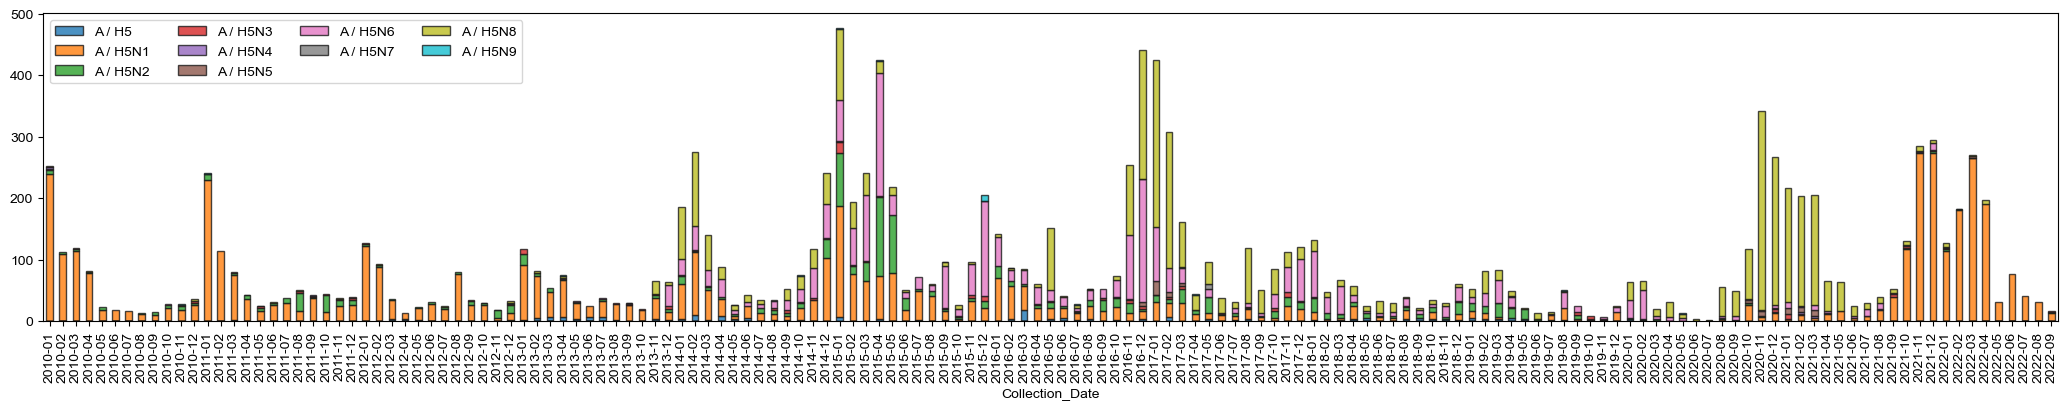

In [287]:
tmp = all_h5_info.groupby([ts_m, all_h5_info.Subtype]).size().unstack(1).resample('M', kind='period').sum().fillna(0)
tmp.plot.bar(stacked=True, edgecolor='.1', alpha=.8, rot=90, figsize=(26, 4))
plt.legend(ncols=4, loc=2);


## unify sequence data

In [25]:
all_h5_seq_dict = SeqIO.to_dict(SeqIO.parse(original_data_dir+all_h5_seqs_file, 'fasta'), key_function=lambda x: "EPI"+x.id.split('|')[0])

In [27]:
tt = defaultdict(list)

for record in SeqIO.parse(original_data_dir+all_h5_seqs_file, 'fasta'):
    seg_id, isl_id, isl_name, _, ctime, seg_name, _ = record.id.split('|')
    tt['Isolate_Id'].append(isl_id)
    tt['Isolate_Name'].append(isl_name)
    tt['Segment_Id'].append('EPI'+seg_id)
    tt['Segment_Name'].append(seg_name)
    tt['Sequence'].append(str(record.seq))

all_h5_seg_info = pd.DataFrame(tt)
all_h5_seg_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence
0,EPI_ISL_71033,A/chicken/Egypt/1052S-NLQP/2010,EPI246016,HA,atgcaaacaactcaacagagcaggttgacacaataatggaaaagaa...
1,EPI_ISL_73327,A/reassortant/IDCDC-RG13(Egypt/3300-NAMRU3/200...,EPI251453,HA,atggagaaaatagtgcttcttcttgcaatagtcagtcttgttaaaa...
2,EPI_ISL_73327,A/reassortant/IDCDC-RG13(Egypt/3300-NAMRU3/200...,EPI251454,NA,atgaatccaaatcagaagataataaccatcggatcaatctgtatgg...
3,EPI_ISL_74303,A/Egypt/N00269/2010,EPI255359,HA,atggagaaaatagtgcttcttcttgcaatagccagtcttgttaaaa...
4,EPI_ISL_74303,A/Egypt/N00269/2010,EPI255360,NA,atgaatccaaatcagaagataataaccatcgggtcaatctgtatgg...


In [163]:
# fw = open('HA_sequences_after_2010.fasta', 'w')
# for _, item in all_h5_seg_info.query("Segment_Name == 'HA'").iterrows():
#     fw.write(f">{item['Isolate_Id']}\n{item['Sequence']}\n")
# fw.close()

In [164]:
# def unify_seg_id(string):
#     targets = re.findall('EPI\d+', string)
#     if not targets:
#         pass
#     if len(targets) == 1:
#         return targets[0]
#     else:
#         seq_lengths = [len(all_h5_seq_dict.get(target, [])) for target in targets]
#         idx = np.argmax(np.array(seq_lengths))
#         return targets[idx]

# tmp['Segment_ID'] = tmp['value'].map(unify_seg_id)
# tmp

### drop low quality sequences based on length 1.5*IQR

In [165]:
def index_sequence(seq):
    # length A C G T N other_IUPAC - ? invalid_nucleotides
    # strain_name = record.id.split('|')[0]
    seq_len = len(seq)
    seq = seq.upper()
    count_a = seq.count('A')
    count_c = seq.count('C')
    count_g = seq.count('G')
    count_t = seq.count('T')
    other_IUPAC = ['RYSWKMBDHV']
    count_other = sum([seq.count(x) for x in other_IUPAC])
    count_N = seq.count('N')
    count_gap = seq.count('-')
    count_q = seq.count('?')
    count_invalid = seq_len - count_a - count_c - count_g - count_t - count_other - count_N - count_gap - count_q
    return [seq_len, count_a, count_c, count_g, count_t, count_other, count_N, count_gap, count_q, count_invalid]

In [166]:
seq_index = pd.DataFrame(all_h5_seg_info.Sequence.map(index_sequence).tolist(), columns=['seq_len', 'count_a', 'count_c', 'count_g', 'count_t', 'count_other', 'count_N', 'count_gap', 'count_q', 'count_invalid'])

all_h5_seg_info = pd.concat([all_h5_seg_info, seq_index], axis=1)
all_h5_seg_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid
0,EPI_ISL_71033,A/chicken/Egypt/1052S-NLQP/2010,EPI246016,HA,atgcaaacaactcaacagagcaggttgacacaataatggaaaagaa...,1584,570,293,366,355,0,0,0,0,0
1,EPI_ISL_73327,A/reassortant/IDCDC-RG13(Egypt/3300-NAMRU3/200...,EPI251453,HA,atggagaaaatagtgcttcttcttgcaatagtcagtcttgttaaaa...,1695,593,309,386,407,0,0,0,0,0
2,EPI_ISL_73327,A/reassortant/IDCDC-RG13(Egypt/3300-NAMRU3/200...,EPI251454,NA,atgaatccaaatcagaagataataaccatcggatcaatctgtatgg...,1350,398,242,345,365,0,0,0,0,0
3,EPI_ISL_74303,A/Egypt/N00269/2010,EPI255359,HA,atggagaaaatagtgcttcttcttgcaatagccagtcttgttaaaa...,1704,600,311,385,405,0,0,0,0,3
4,EPI_ISL_74303,A/Egypt/N00269/2010,EPI255360,NA,atgaatccaaatcagaagataataaccatcgggtcaatctgtatgg...,1350,398,245,347,360,0,0,0,0,0


In [167]:
len_thr = {}
for seg in seg_l:
    t = all_h5_seg_info.query("Segment_Name == @seg")['seq_len'].quantile([0.25, 0.75])
    q1,q3 = t.values
    l = q1 - (q3-q1)*1.5
    u = q3 + (q3-q1)*1.5
    len_thr[seg] = (l, u)
    print(seg, l, u)

PB2 2214.0 2390.0
PB1 2209.5 2381.5
PA 2065.5 2293.5
HA 1635.0 1819.0
NP 1431.0 1607.0
NA 1282.5 1518.5
NS 794.5 910.5
MP 938.5 1054.5


In [168]:
seq_with_low_quality = []

for _, row in all_h5_seg_info.iterrows():
    seg_name = row['Segment_Name']
    seq_length = row['seq_len']
    thr_l, thr_u = len_thr[seg_name]
    if seq_length < thr_l or seq_length > thr_u:
        seq_with_low_quality.append(row['Segment_Id'])

print(f"Drop {len(seq_with_low_quality)} sequences with low quality\n")

tmp = all_h5_seg_info[all_h5_seg_info.Segment_Id.isin(seq_with_low_quality)].index
all_h5_seg_info = all_h5_seg_info.drop(index=tmp)

all_h5_seg_info.head()

Drop 5096 sequences with low quality



,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid
1,EPI_ISL_73327,A/reassortant/IDCDC-RG13(Egypt/3300-NAMRU3/200...,EPI251453,HA,atggagaaaatagtgcttcttcttgcaatagtcagtcttgttaaaa...,1695,593,309,386,407,0,0,0,0,0
2,EPI_ISL_73327,A/reassortant/IDCDC-RG13(Egypt/3300-NAMRU3/200...,EPI251454,NA,atgaatccaaatcagaagataataaccatcggatcaatctgtatgg...,1350,398,242,345,365,0,0,0,0,0
3,EPI_ISL_74303,A/Egypt/N00269/2010,EPI255359,HA,atggagaaaatagtgcttcttcttgcaatagccagtcttgttaaaa...,1704,600,311,385,405,0,0,0,0,3
4,EPI_ISL_74303,A/Egypt/N00269/2010,EPI255360,NA,atgaatccaaatcagaagataataaccatcgggtcaatctgtatgg...,1350,398,245,347,360,0,0,0,0,0
5,EPI_ISL_74304,A/Egypt/N00270/2010,EPI255361,HA,atggagaaaatagtgcttcttcttgcaatagtcagtattgttaaaa...,1704,603,309,386,406,0,0,0,0,0


### drop multiple sequencing segment with keeping sequence with longest length

In [169]:
all_h5_seg_info = all_h5_seg_info.sort_values(by=['Isolate_Id', 'Segment_Name', 'seq_len'])

duplicated = all_h5_seg_info[all_h5_seg_info.duplicated(['Isolate_Id', 'Segment_Name'], keep=False)]
keeped = all_h5_seg_info[all_h5_seg_info.duplicated(['Isolate_Id', 'Segment_Name'], keep='last')]
print(f"drop {duplicated.shape[0] - keeped.shape[0]} duplicated sequences")

all_h5_seg_info = all_h5_seg_info.drop_duplicates(['Isolate_Id', 'Segment_Name'], keep='last')

drop 125 duplicated sequences


### align sequences

In [172]:
def align_to_ref(seg):
    tmp_set = all_h5_seg_info.query('Segment_Name == @seg')
    ref_seq = ref_sequences[seg]

    with open(f'ref_{seg}.fasta', 'w') as f:
        f.write(f">ref_{seg}\n{ref_seq}\n")

    with open(f'other_{seg}.fasta', 'w') as f:
        for _, row in tmp_set.iterrows():
            acc = row['Segment_Id']
            seq = row['Sequence']
            f.write(f">{acc}\n{seq}\n")

    cmd = f"mafft --quiet --anysymbol --6merpair --keeplength --addfragments other_{seg}.fasta ref_{seg}.fasta > align_{seg}.fasta"
    status = os.system(cmd)
    
    acc2seq = SeqIO.to_dict(SeqIO.parse(f'align_{seg}.fasta', 'fasta'))
    del acc2seq[f'ref_{seg}']

    os.remove(f'other_{seg}.fasta')
    os.remove(f'ref_{seg}.fasta')
    os.remove(f'align_{seg}.fasta')
    return acc2seq


In [ ]:
with Pool(8) as p:
    res = p.map(align_to_ref, seg_l)

In [175]:
acc2seqs = {k: v for item in res for k, v in item.items()}
all_h5_seg_info['Align_sequences'] = all_h5_seg_info['Segment_Id'].map(lambda x: str(acc2seqs[x].seq))

In [176]:
all_h5_seg_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid,Align_sequences
1426,EPI_ISL_100257,A/chicken/Vietnam/NCVD-427/2010,EPI347289,HA,atggagaaaatagtgcttctttttgcgatagtcagtcttgttaaaa...,1707,582,311,404,409,0,0,0,0,1,atggagaaaatagtgcttctttttgcgatagtcagtcttgttaaaa...
1481,EPI_ISL_100257,A/chicken/Vietnam/NCVD-427/2010,EPI348813,MP,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcatcc...,982,282,212,259,229,0,0,0,0,0,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcatcc...
1485,EPI_ISL_100257,A/chicken/Vietnam/NCVD-427/2010,EPI348817,NA,atgaatccaaatcagaagataataacaatcggatcaatctgtatgg...,1350,405,247,339,359,0,0,0,0,0,atgaatccaaatcagaagataataacaatcggatcaatctgtatgg...
1479,EPI_ISL_100257,A/chicken/Vietnam/NCVD-427/2010,EPI348811,NP,atggcgtctcaaggcaccaaacgatcttatgaacaaatggagacta...,1497,477,298,411,311,0,0,0,0,0,atggcgtctcaaggcaccaaacgatcttatgaacaaatggagacta...
1480,EPI_ISL_100257,A/chicken/Vietnam/NCVD-427/2010,EPI348812,NS,atggactccaacactgtgtcaagctttcaggtagactgctttcttt...,823,260,168,201,194,0,0,0,0,0,atggactccaacactgtgtcaagctttcaggtagactgctttcttt...


### drop LPAIV isolates based on HA gene

In [177]:
multiple_basic_cleavage = (1015-1, 1035-1)
ms, me = multiple_basic_cleavage

mbc_motif = []
for _, row in all_h5_seg_info.query('Segment_Name == "HA"').iterrows():
    
    isl_acc = row['Isolate_Id']
    seg_acc = row['Segment_Id']
    seq = Seq.Seq(row['Align_sequences'])
    
    seq = seq[ms: me+1]
    try:
        v_ = str(seq.translate())
        mbc_motif.append(list(v_))
    except:
        print(f'{isl_acc:20} {str(seq)}')

print()
        
M1, M2, M3, M4, M5, M6, M7 = zip(*mbc_motif)

def count_site(site_list):
    most_common = Counter(site_list).most_common(1)[0]
    total = sum(Counter(site_list).values())
    print(f"Total {total} sites, the most common base is {most_common[0]} with {most_common[1]} ({most_common[1]/total:.4f}) sites.")

for i in range(1, 8):
    tmp = locals()[f'M{i}']
    count_site(tmp)

EPI_ISL_107968       attca---------atccaga
EPI_ISL_11050897     aggga---------aacaaga
EPI_ISL_112297       -------aaagagccacaaga
EPI_ISL_119465       ----aaagaagaaaaaaaaga
EPI_ISL_119466       ----aaagaagaaaaaaaaga
EPI_ISL_125796       aaaga---------aacaaga
EPI_ISL_125801       aaaga---------aacaaga
EPI_ISL_12801398     agaga---------gacaaga
EPI_ISL_12853041     agaga---------gacaaga
EPI_ISL_129960       -------aaaggaagacaaga
EPI_ISL_130104       agaga---------aacaaga
EPI_ISL_130106       agaga---------aacaaga
EPI_ISL_131279       agaga---------aacaaga
EPI_ISL_133636       agaga---------aacaaga
EPI_ISL_133637       agaga---------aacaaga
EPI_ISL_133638       agaga---------aacaaga
EPI_ISL_133639       agaga---------aacaaga
EPI_ISL_133640       agaga---------aacaaga
EPI_ISL_133641       agaga---------aacaaga
EPI_ISL_133653       agaga---------aacaaga
EPI_ISL_133655       ----aaagaagaaaaaaaaga
EPI_ISL_133656       ----aaagaagaaaaaaaaga
EPI_ISL_133657       ----aaagaagaaaaaaaaga
EPI_ISL_134

In [178]:
multiple_basic_cleavage = (1015-1, 1035-1)
ms, me = multiple_basic_cleavage

isl_without_mbc = []

for _, row in all_h5_seg_info.query('Segment_Name == "HA"').iterrows():
    
    isl_acc = row['Isolate_Id']
    seg_acc = row['Segment_Id']
    seq = Seq.Seq(row['Align_sequences'])
    seq = seq[ms: me+1]
    
    try:
        v = str(seq.translate())
        ct = 0
        for i, j in zip('REKRRKR', v):
            if i != j:
                ct += 1
        if ct > 3:
            print(f'{isl_acc:20} {v}')
            isl_without_mbc.append(isl_acc)
    except:
        print(f'{isl_acc:20} {seq}')
        isl_without_mbc.append(isl_acc)

EPI_ISL_101992       GETRG--
EPI_ISL_10406912     IETRG--
EPI_ISL_1041174      RETRG--
EPI_ISL_104522       RETRG--
EPI_ISL_104523       RETRG--
EPI_ISL_104524       RETRG--
EPI_ISL_107968       attca---------atccaga
EPI_ISL_11050897     aggga---------aacaaga
EPI_ISL_11207832     RETRG--
EPI_ISL_11211428     RETRG--
EPI_ISL_11212324     RETRG--
EPI_ISL_112297       -------aaagagccacaaga
EPI_ISL_116137       RETRG--
EPI_ISL_119465       ----aaagaagaaaaaaaaga
EPI_ISL_119466       ----aaagaagaaaaaaaaga
EPI_ISL_121253       RETRG--
EPI_ISL_125796       aaaga---------aacaaga
EPI_ISL_125801       aaaga---------aacaaga
EPI_ISL_1263541      KETRG--
EPI_ISL_12801398     agaga---------gacaaga
EPI_ISL_12853041     agaga---------gacaaga
EPI_ISL_129960       -------aaaggaagacaaga
EPI_ISL_130104       agaga---------aacaaga
EPI_ISL_130106       agaga---------aacaaga
EPI_ISL_131279       agaga---------aacaaga
EPI_ISL_131280       RETRG--
EPI_ISL_131281       RETRG--
EPI_ISL_131282       RETRG--
EPI_IS

In [179]:
print(f"Drop following {len(isl_without_mbc)} isolates due to not have multiple cleavage sites")

all_h5_seg_info = all_h5_seg_info[~all_h5_seg_info.Isolate_Id.isin(isl_without_mbc)]

Drop following 775 isolates due to not have multiple cleavage sites


## output all ha sequences to build a ha tree and select isolates belong to 2.3.4.4

In [35]:
# with open('all_h5_ha.fasta', 'w') as f:
#     for _, v in all_h5_seg_info.query("Segment_Name == seg").iterrows():
#         acc, seq = v['Isolate_Id'], v['Align_sequences']
#         f.write(f'>{acc}\n{seq}\n')

### !! manul drop based on visual check

In [185]:
with open('./data/2344b.txt') as f:
    acc_2334 = f.read().split('\n')

In [198]:
clade2334b_filter = all_h5_seg_info.Isolate_Id.isin(acc_2334)
not_clade2334b = all_h5_seg_info[~clade2334b_filter]
all_h5_seg_info = all_h5_seg_info[clade2334b_filter].copy()
print(f"Drop {len(not_clade2334b.Isolate_Id.unique())} isolates with {not_clade2334b.shape[0]} sequences not in clade 2.3.4.4b")

Drop 7249 isolates with 43368 sequences not in clade 2.3.4.4b


In [199]:
# cond = all_h5n8_seg_info[all_h5n8_seg_info.Segment_Id == 'EPI2044655'].index
# all_h5n8_seg_info = all_h5n8_seg_info.drop(cond)

In [200]:
# cond = all_h5n8_seg_info[all_h5n8_seg_info.Isolate_Id == 'EPI_ISL_179386'].index
# all_h5n8_seg_info = all_h5n8_seg_info.drop(cond)

In [274]:
# all_h5_seg_info.to_csv('seg_info_h5.csv', sep='\t', index=False)
all_h5_seg_info = pd.read_csv('seg_info_h5.csv', sep='\t', na_filter=False)
all_h5_seg_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid,Align_sequences
0,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846416,HA,agcaggggtttactctgtcaaaatggagaacatagtacttcttctt...,1762,604,330,408,420,0,0,0,0,0,atggagaacatagtacttcttcttgcaatagttagccttgttaaaa...
1,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846411,MP,aagcaggtagatattgaaagatgagtcttctaaccgaggtcgaaac...,1005,281,219,275,230,0,0,0,0,0,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...
2,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846415,NA,atgaatccaaatcagaagataataacaattggctctgtctctctaa...,1440,449,279,338,374,0,0,0,0,0,atgaatccaaatcagaagataataacaattggctctgtctctctaa...
3,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846409,NP,agcagggtagataatcactcactgagtgacatcaacatcatggcgt...,1551,492,313,417,328,0,0,0,0,1,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...
4,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846410,NS,gcagggtgacaaaaacataatggatcccaacactatgttaagcttt...,876,282,169,209,216,0,0,0,0,0,atggatcccaacactatgttaagctttcaggtagactgttttcttt...


In [275]:
seg2seq = all_h5_seg_info.set_index('Segment_Id')['Align_sequences'].to_dict()
seg2isl = all_h5_seg_info.set_index('Segment_Id')['Isolate_Id'].to_dict()

### transpose long table to wide table

#### all isolates

In [276]:
all_h5_seg_info_w = pd.pivot(index='Isolate_Id', columns='Segment_Name', values='Segment_Id', data=all_h5_seg_info)
all_h5_seg_info_w.head()

Segment_Name,HA,MP,NA,NP,NS,PA,PB1,PB2
Isolate_Id,,,,,,,,
EPI_ISL_1005680,EPI1846416,EPI1846411,EPI1846415,EPI1846409,EPI1846410,EPI1846412,EPI1846414,EPI1846413
EPI_ISL_1009679,EPI1846450,EPI1846445,EPI1846449,EPI1846443,EPI1846444,EPI1846446,EPI1846448,EPI1846447
EPI_ISL_1009680,EPI1850620,EPI1850660,EPI1846457,EPI1846451,EPI1846452,EPI1846454,EPI1846456,EPI1846455
EPI_ISL_1009681,EPI1850621,EPI1850661,EPI1846465,EPI1846459,EPI1846460,EPI1846462,EPI1846464,EPI1846463
EPI_ISL_1009682,EPI1850622,EPI1850662,EPI1846473,EPI1846467,EPI1846468,EPI1846470,EPI1846472,EPI1846471


#### full genome

In [277]:
all_h5_seg_info_w2 = all_h5_seg_info_w.dropna(how='any')
all_h5_seg_info_w2.head()

Segment_Name,HA,MP,NA,NP,NS,PA,PB1,PB2
Isolate_Id,,,,,,,,
EPI_ISL_1005680,EPI1846416,EPI1846411,EPI1846415,EPI1846409,EPI1846410,EPI1846412,EPI1846414,EPI1846413
EPI_ISL_1009679,EPI1846450,EPI1846445,EPI1846449,EPI1846443,EPI1846444,EPI1846446,EPI1846448,EPI1846447
EPI_ISL_1009680,EPI1850620,EPI1850660,EPI1846457,EPI1846451,EPI1846452,EPI1846454,EPI1846456,EPI1846455
EPI_ISL_1009681,EPI1850621,EPI1850661,EPI1846465,EPI1846459,EPI1846460,EPI1846462,EPI1846464,EPI1846463
EPI_ISL_1009682,EPI1850622,EPI1850662,EPI1846473,EPI1846467,EPI1846468,EPI1846470,EPI1846472,EPI1846471


In [278]:
print(f"{all_h5_seg_info_w.shape[0]} isolates")
print(f"{all_h5_seg_info_w2.shape[0]} isolates with full genome")

4788 isolates
3934 isolates with full genome


## merge sequences file and meta information file

In [279]:
# con = '\n'.join(all_h5_data2.index.to_list())
# with open('test_epi_set.csv', 'w') as f:
    # f.write(con)

In [288]:
all_h5_data = pd.merge(all_h5_seg_info_w, all_h5_info[cols], left_index=True, right_on='Isolate_Id', ).set_index('Isolate_Id')
all_h5_data2 = pd.merge(all_h5_seg_info_w2, all_h5_info[cols], left_index=True, right_on='Isolate_Id', ).set_index('Isolate_Id')

In [289]:
# all_h5_data.to_csv('isl_info_h5_1.csv', sep='\t', index=True)
# all_h5_data2.to_csv('isl_info_h5.csv', sep='\t', index=True)
all_h5_data2 = pd.read_csv('isl_info_h5.csv', sep='\t', parse_dates=True, index_col=0)

all_h5_data2['date'] = pd.to_datetime(all_h5_data2.Collection_Date)
all_h5_data2 = all_h5_data2[all_h5_data2.date > pd.to_datetime('2016-09-01')]
all_h5_data2 = all_h5_data2.sort_values(by='date')

all_h5_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3781 entries, EPI_ISL_386922 to EPI_ISL_15364794
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   HA               3781 non-null   object        
 1   MP               3781 non-null   object        
 2   NA               3781 non-null   object        
 3   NP               3781 non-null   object        
 4   NS               3781 non-null   object        
 5   PA               3781 non-null   object        
 6   PB1              3781 non-null   object        
 7   PB2              3781 non-null   object        
 8   Isolate_Name     3781 non-null   object        
 9   Subtype          3781 non-null   object        
 10  Location         3781 non-null   object        
 11  Host             3781 non-null   object        
 12  Domestic_Status  1161 non-null   object        
 13  Collection_Date  3781 non-null   object        
 14  Submission_Date  378

In [290]:
# all_h5_data2['subtype'] = all_h5_data2.Subtype.map(parse_serotype)
# all_h5_data2['host'] = all_h5_data2.Isolate_Name.str.split('/').str.get(1)
# all_h5_data2['region'] = all_h5_data2.Location.str.split(' / ').str.get(0)
# all_h5_data2['country'] = all_h5_data2.Location.str.split(' / ').str.get(1)
# all_h5_data2['province'] = all_h5_data2.Location.str.split(' / ').str.get(2)
# all_h5_data2['city'] = all_h5_data2.Location.str.split(' / ').str.get(3)

In [291]:
all_h5_data2.loc[all_h5_data2.date>pd.Timestamp('2019-12-01')].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2965 entries, EPI_ISL_402134 to EPI_ISL_15364794
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   HA               2965 non-null   object        
 1   MP               2965 non-null   object        
 2   NA               2965 non-null   object        
 3   NP               2965 non-null   object        
 4   NS               2965 non-null   object        
 5   PA               2965 non-null   object        
 6   PB1              2965 non-null   object        
 7   PB2              2965 non-null   object        
 8   Isolate_Name     2965 non-null   object        
 9   Subtype          2965 non-null   object        
 10  Location         2965 non-null   object        
 11  Host             2965 non-null   object        
 12  Domestic_Status  881 non-null    object        
 13  Collection_Date  2965 non-null   object        
 14  Submission_Date  296

In [292]:
# tmp = all_h5_data2[[seg,'date']].copy()
# tmp['decimalDate'] = tmp['date'].map(lambda x: bt.decimalDate(datetime.strftime(x, '%Y-%m-%d')))
# tmp[['HA', 'decimalDate']].to_csv('./data/01_h5_2334b/dates.csv', index=False)

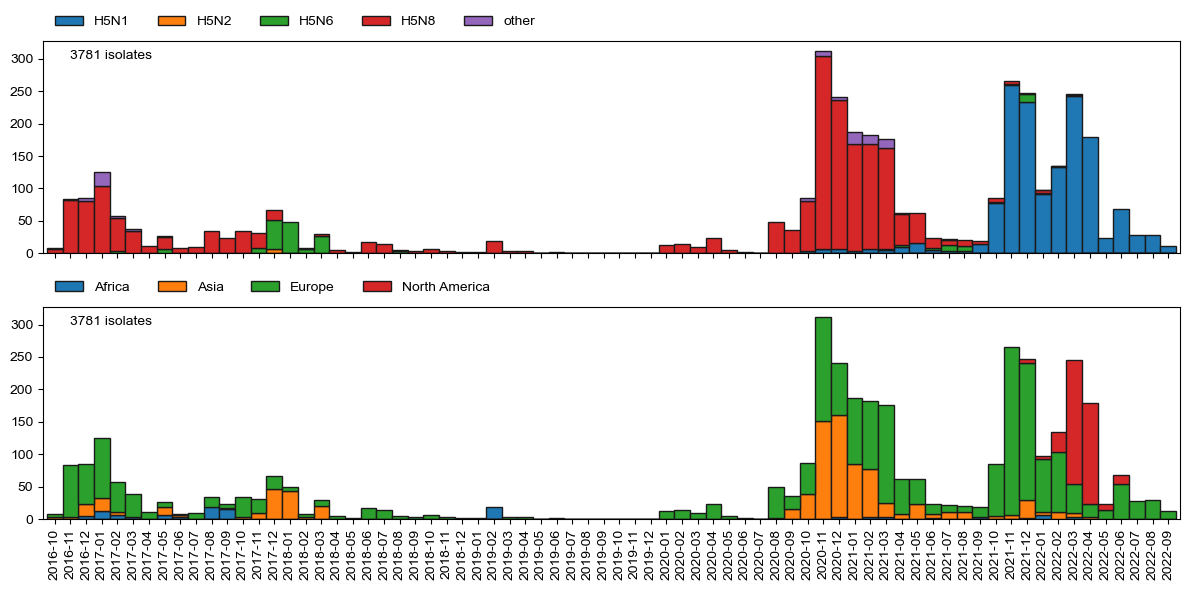

In [293]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ts_m = all_h5_data2.date.map(lambda x: x.to_period('M'))

(all_h5_data2.groupby([ts_m, 'subtype']).size().unstack(1).resample('M').sum().fillna(0)
                                        .plot(kind='bar', stacked=True, width=1, edgecolor='.1', ax=axs[0]))
axs[0].legend(loc='lower left', bbox_to_anchor=(0, 1), ncols=5, frameon=False)
axs[0].text(1, 300, f"{all_h5_data2.shape[0]} isolates")

(all_h5_data2.groupby([ts_m, 'region']).size().unstack(1).resample('M').sum().fillna(0)
                                        .plot(kind='bar', stacked=True, width=1, edgecolor='.1', ax=axs[1]))
axs[1].legend(loc='lower left', bbox_to_anchor=(0, 1), ncols=5, frameon=False)
axs[1].text(1, 300, f"{all_h5_data2.shape[0]} isolates")
axs[1].set_xlabel('')

plt.tight_layout()
plt.show();

# output h5 segment sequences

In [294]:
all_h5_seg_info= pd.read_csv('./seg_info_h5.csv', sep='\t', keep_default_na=False)
all_h5_seg_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid,Align_sequences
0,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846416,HA,agcaggggtttactctgtcaaaatggagaacatagtacttcttctt...,1762,604,330,408,420,0,0,0,0,0,atggagaacatagtacttcttcttgcaatagttagccttgttaaaa...
1,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846411,MP,aagcaggtagatattgaaagatgagtcttctaaccgaggtcgaaac...,1005,281,219,275,230,0,0,0,0,0,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...
2,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846415,NA,atgaatccaaatcagaagataataacaattggctctgtctctctaa...,1440,449,279,338,374,0,0,0,0,0,atgaatccaaatcagaagataataacaattggctctgtctctctaa...
3,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846409,NP,agcagggtagataatcactcactgagtgacatcaacatcatggcgt...,1551,492,313,417,328,0,0,0,0,1,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...
4,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846410,NS,gcagggtgacaaaaacataatggatcccaacactatgttaagcttt...,876,282,169,209,216,0,0,0,0,0,atggatcccaacactatgttaagctttcaggtagactgttttcttt...


In [295]:
seg2seq = all_h5_seg_info.set_index('Segment_Id')['Align_sequences'].to_dict()
seg2isl = all_h5_seg_info.set_index('Segment_Id')['Isolate_Id'].to_dict()

In [296]:
ts2 = pd.to_datetime(all_h5_data2.Collection_Date)
all_h5_data2[ts2 > datetime(2019, 10, 1)].shape

(2965, 25)

## output isolates belong 2.3.4.4

In [297]:
if not os.path.exists('./data/01_h5_2344b'):
    os.mkdir('./data/01_h5_2344b')

all_h5_data_dir = './data/01_h5_2344b/'

tmp = all_h5_data2

for seg in seg_l:
    tt = tmp[seg].dropna().values
    tt = all_h5_seg_info.query("Segment_Id in @tt")
    # tt = tt.drop_duplicates(['Align_sequences'])
    print(f"Number of unique sequences for {seg}: ", tt.shape[0])

    # with open(all_h5_data_dir+f'h5_2344b_{seg}.align.fasta', 'w') as f:
    #     for _, row in tt.iterrows():
    #         acc = row['Segment_Id']
    #         seq = row['Align_sequences']
    #         f.write(f">{acc}\n{seq}\n")

Number of unique sequences for PB2:  3781
Number of unique sequences for PB1:  3781
Number of unique sequences for PA:  3781
Number of unique sequences for HA:  3781
Number of unique sequences for NP:  3781
Number of unique sequences for NA:  3781
Number of unique sequences for NS:  3781
Number of unique sequences for MP:  3781


## output isolates between Oct 2019 to Dec 2021

In [298]:
if not os.path.exists('./data/01_h5_2344b_after2019'):
    os.mkdir('./data/01_h5_2344b_after2019')

all_h5_data_dir = './data/01_h5_2344b_after2019/'

ts = pd.to_datetime(all_h5_data2.Collection_Date)
tmp = all_h5_data2[ts > datetime(2019, 10, 1)]

for seg in seg_l:
    tt = tmp[seg].dropna().values
    tt = all_h5_seg_info.query("Segment_Id in @tt")
    # tt = tt.drop_duplicates(['Align_sequences'])
    print(f"Number of unique sequences for {seg}: ", tt.shape[0])

    # with open(all_h5_data_dir+f'h5_2344b_{seg}.align.fasta', 'w') as f:
    #     for _, row in tt.iterrows():
    #         acc = row['Segment_Id']
    #         seq = row['Align_sequences']
    #         f.write(f">{acc}\n{seq}\n")


#     with open(all_h5_data_dir+f'h5_2344b_{seg}.fasta', 'w') as f:
#         for _, row in tt.iterrows():
#             acc = row['Segment_Id']
#             seq = row['Sequence']
#             f.write(f">{acc}\n{seq}\n")
            
#     with open(all_h5_data_dir+f'h5_2344b_{seg}_acc.txt', 'w') as f:
#         for _, row in tt.iterrows():
#             f.write(f"{row['Segment_Id']}\n")



Number of unique sequences for PB2:  2965
Number of unique sequences for PB1:  2965
Number of unique sequences for PA:  2965
Number of unique sequences for HA:  2965
Number of unique sequences for NP:  2965
Number of unique sequences for NA:  2965
Number of unique sequences for NS:  2965
Number of unique sequences for MP:  2965


# HA tree for all 2.3.4.4 H5

In [299]:
def setAbsoluteTime(tree, dates):
    for i in tree.Objects:
        if i.is_leaf():
            i.absoluteTime=float(dates.loc[i.name, 'numeric date'])
        else:
            i.absoluteTime=float(dates.loc[i.traits['label'], 'numeric date'])
    tree.mostRecent = float(dates['numeric date'].max())
    return tree

In [300]:
outliers = ['EPI1897173', 'EPI1215152', 'EPI1215461', 'EPI1215437', 'EPI1215144', 'EPI1215176', 'EPI1104275', 'EPI1104299', 'EPI1977581', 'EPI1896419', 'EPI1574305', 'EPI1807347', 'EPI1815191', 'EPI1890404', 'EPI1890500']

In [301]:
dates = pd.read_csv('./data/01_h5_2344b/treetime/dates.tsv', sep='\t', index_col=0)

tree_file = './data/01_h5_2344b/treetime/timetree.nexus'
tree = dendropy.Tree.get(path=tree_file, schema='nexus', extract_comment_metadata=True)
tree.prune_taxa_with_labels(outliers)
treeString = tree.as_string(schema='newick', suppress_rooting=True, suppress_annotations=True, annotations_as_nhx=False)

ll=bt.loadNewick(StringIO(treeString), tip_regex='_([0-9\-]+)$', absoluteTime=False)
ll=setAbsoluteTime(ll, dates)
ll.renameTips(seg2isl)

In [302]:
time_bin_label = ['2016-09-01', '2017-08-30', '2019-10-01', '2020-09-01', '2021-09-01', '2022-12-31']
time_bin_label = [datetime.strptime(x, '%Y-%m-%d') for x in time_bin_label]

cats = pd.cut(all_h5_data2['date'], time_bin_label, labels=['16/17 Wave', '17/19 Static', '19/20 Wave', '20/21 Wave', '21/22 Wave'])
categories = cats.values.categories.to_list()

isl2time = cats.dropna().to_dict()
isl2cat = cats.to_dict()

isl2subtype = all_h5_data2['subtype'].to_dict()
isl2region = all_h5_data2['region'].to_dict()

In [303]:
wave1_set = [k.y for k in ll.getExternal() if isl2cat.get(k.name) == '16/17 Wave']
wave2_set = [k.y for k in ll.getExternal() if isl2cat.get(k.name) == '19/20 Wave']
wave3_set = [k.y for k in ll.getExternal() if isl2cat.get(k.name) == '20/21 Wave']
wave4_set = [k.y for k in ll.getExternal() if isl2cat.get(k.name) == '21/22 Wave']

wave1_l, wave1_u = min(wave1_set), max(wave1_set)
wave2_l, wave2_u = min(wave2_set), max(wave2_set)
wave3_l, wave3_u = min(wave3_set), max(wave3_set)
wave4_l, wave4_u = min(wave4_set), max(wave4_set)


subtype1_set = [k.y for k in ll.getExternal() if isl2subtype.get(k.name) == 'H5N8']
subtype2_set = [k.y for k in ll.getExternal() if isl2subtype.get(k.name) == 'H5N6']
subtype3_set = [k.y for k in ll.getExternal() if isl2subtype.get(k.name) == 'H5N1']

subtype1_l, subtype1_u = min(subtype1_set), max(subtype1_set)
subtype2_l, subtype2_u = min(subtype2_set), max(subtype2_set)
subtype3_l, subtype3_u = min(subtype3_set), max(subtype3_set)


region1_set = [k.y for k in ll.getExternal() if isl2region.get(k.name) == 'Europe']
region2_set = [k.y for k in ll.getExternal() if isl2region.get(k.name) == 'Asia']
region3_set = [k.y for k in ll.getExternal() if isl2region.get(k.name) == 'North America']
region4_set = [k.y for k in ll.getExternal() if isl2region.get(k.name) == 'Africa']

region1_l, region1_u = min(region1_set), max(region1_set)
region2_l, region2_u = min(region2_set), max(region2_set)
region3_l, region3_u = min(region3_set), max(region3_set)
region4_l, region4_u = min(region4_set), max(region4_set)

In [304]:
h5n8_sam = pd.read_csv('./data/RE_ Invitation to Co-Author on H5 HPAIV Phylogeography Manuscript from China Agriculture University/aw1617_sequence_details.csv')

h5n8_sam['id'] = h5n8_sam['Accn_4.H5'].apply(lambda x: "EPI_ISL_" + str(x))
h5n8_sam.head()

,Accn_1,Accn_2,Accn_3,Accn_4.H5,Accn_5,Accn_6.N5,Accn_6.N8,Accn_7,Accn_8,Subtype,...,Seg2,Seg3,Seg4.H5,Seg5,Seg6.N5,Seg6.N8,Seg7,Seg8,wg_codes,id
0,224580,224580,224580,224580,224580,0,224580,224580,224580,H5N8,...,A,B,A,D,0,A,A,A,CABAD0AAA,EPI_ISL_224580
1,224726,224726,224726,224726,224726,0,224726,224726,224726,H5N8,...,A,B,A,D,0,A,A,A,CABAD0AAA,EPI_ISL_224726
2,224740,224740,224740,224740,224740,0,224740,224740,224740,H5N8,...,A,B,A,D,0,A,A,A,CABAD0AAA,EPI_ISL_224740
3,224743,224743,224743,224743,224743,0,224743,224743,224743,H5N8,...,A,B,A,D,0,A,A,A,CABAD0AAA,EPI_ISL_224743
4,224751,224751,224751,224751,224751,0,224751,224751,224751,H5N8,...,A,B,A,D,0,A,A,A,CABAD0AAA,EPI_ISL_224751


In [305]:
pd.merge(all_h5_data2, h5n8_sam, left_index=True, right_on='id')[['HA', 'date', 'wg_codes', 'Isolate_Name']].to_csv('check_sam_genotype.csv', index=False, sep='\t')

In [306]:
sam_map = h5n8_sam.set_index('id')['wg_codes'].to_dict()

In [307]:
sam_map2 = defaultdict(list)
for leaf in ll.getExternal():
    if leaf.name in sam_map:
        sam_map2[sam_map[leaf.name]].append([leaf.name, leaf.y])

In [308]:
sam_map3 = {max(v, key=lambda x: x[1])[0]: k for k, v in sam_map2.items()}
sam_map4 = {min(v, key=lambda x: x[1])[0]: k for k, v in sam_map2.items()}

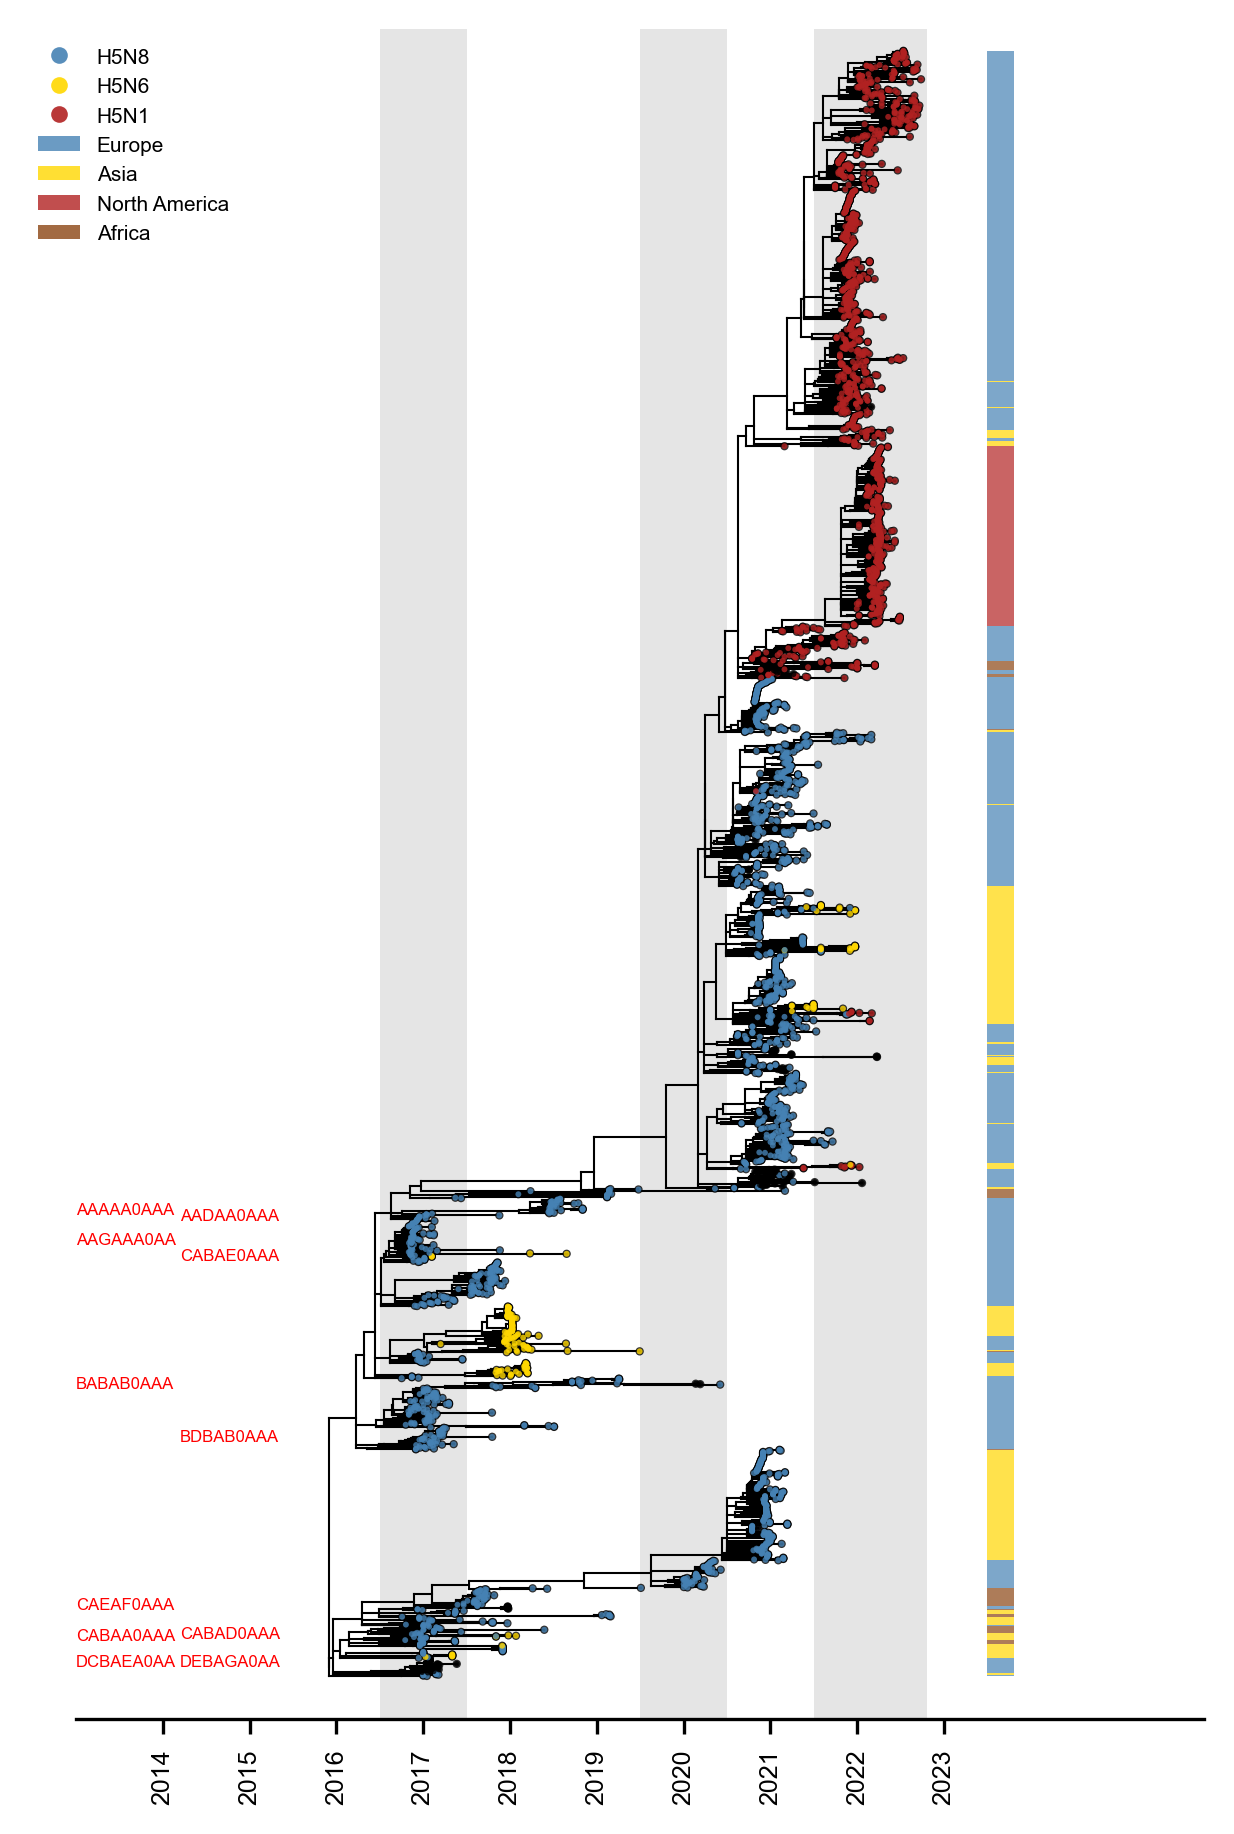

In [189]:
# cmap = cm.get_cmap('Spectral', 5)
# cmap = {'16/17 Wave': 'orange', '19/20 Wave': 'gold', '20/21 Wave': 'steelblue',  '21/22 Wave': 'firebrick'}
cmap2 = {'H5N8': 'steelblue', 'H5N6': 'gold',  'H5N1': 'firebrick'}
cmap = {'Europe': 'steelblue', 'Asia': 'gold',  'North America': 'firebrick', 'Africa': 'saddlebrown'}


treeHeight = ll.treeHeight

fig = plt.subplots(figsize=(4, 6), facecolor='w', dpi=300, constrained_layout=True)
ax = plt.subplot(111)

y_attr=lambda k: -k.y
x_attr=lambda k: k.absoluteTime

def fetch_leaf_color(k):
    cat = isl2subtype.get(k.name)
    if cat:
        return cmap2.get(cat, 'black')
    else:
        return 'black'

color_func = lambda k: fetch_leaf_color(k) if k.branchType == 'leaf' else 'black'

ll.plotTree(ax, width=.5, x_attr=x_attr, y_attr=y_attr)
ll.plotPoints(ax, x_attr=x_attr, y_attr=y_attr, size=2, colour=color_func, zorder=100, alpha=.8)


ct = 0
for leaf in ll.getExternal():
    y = leaf.y
    
    if leaf.name in sam_map4:
        if ct % 2 == 0:
            ax.text(2013, -leaf.y, sam_map.get(leaf.name), fontdict={'fontsize':4, }, color='red')
            ct += 1
        else:
            ax.text(2014.2, -leaf.y, sam_map.get(leaf.name), fontdict={'fontsize':4, }, color='red')
            ct += 1
    
    region = isl2region.get(leaf.name)
    color = cmap.get(region, 'k')

    if not region:
        continue

    rect=plt.Rectangle(
        (2023.5,-leaf.y-1/2),
        .3,
        1,
        facecolor=color,
        edgecolor=color,
        lw=.0, 
        alpha=.7
    )
    ax.add_patch(rect) ## add rectangle to plot    


handles = []
for k, v in cmap2.items():
    handles.append(Line2D([0], [0], lw=0, marker='o', markeredgecolor='none', markersize=4, markerfacecolor=v, label=k, alpha=.9))
for k, v in cmap.items():
    handles.append(Patch(facecolor=v, alpha=.8, edgecolor='none', label=k))
    
# handles.append(Patch(facecolor='k', alpha=.5, edgecolor='none', label='16/17 Wave'))
# handles.append(Patch(facecolor='gold', alpha=.5, edgecolor='none', label='19/20 Wave'))
# handles.append(Patch(facecolor='steelblue', alpha=.5, edgecolor='none', label='20/21 Wave'))
# handles.append(Patch(facecolor='firebrick', alpha=.5, edgecolor='none', label='21/22 Wave'))

ax.legend(handles=handles, frameon=False, fontsize=5, loc='upper left', bbox_to_anchor=(-.05, 1))

# ax.set_xlim(0, treeHeight*1.)
ax.set_xlim(2013, 2026)
ax.set_xticks(np.arange(2014, 2024))
ax.tick_params(axis='x', labelsize=6, rotation=90)

ax.set_ylim(-100-ll.ySpan, 50) ## set y limits
ax.set_yticks([])
ax.set_yticklabels([])

ax.axvspan(2016.5, 2017.5, facecolor='k', edgecolor='none', alpha=.1)
ax.axvspan(2019.5, 2020.5, facecolor='k', edgecolor='none', alpha=.1)
ax.axvspan(2020.5, 2021.5, facecolor='none', edgecolor='none', alpha=.2)
ax.axvspan(2021.5, 2022.8, facecolor='k', edgecolor='none', alpha=.1)


[ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom']
ax.grid(False)


plt.show();

**Figure 1a Maxmium likelihood tree for the HA gene of all 2.3.4.4 HPAI H5 viruses**

# pairwise sequences identity

In [309]:
all_h5_data2 = all_h5_data2.sort_values(by='date')

In [310]:
all_h5_data2['subtype'].value_counts()

H5N8     2007
H5N1     1460
H5N6      196
other     104
H5N2       14
Name: subtype, dtype: int64

In [311]:
time_bin_label = ['2016-09-01', '2017-08-30', '2019-10-01', '2020-09-01', '2021-09-01', '2022-12-31']
time_bin_label = [datetime.strptime(x, '%Y-%m-%d') for x in time_bin_label]

cats = pd.cut(all_h5_data2['date'], time_bin_label, labels=['16/17 Wave', '17/19 Static', '19/20 Wave', '20/21 Wave', '21/22 Wave'])
all_h5_data2['wave'] = cats

In [34]:
# genotype = pd.read_csv('./old_/new_genotype.csv', sep='\t')
# tmp = genotype.set_index('Isolate_Id')['genotype'].to_dict()

# all_h5_data2['genotype'] = all_h5_data2.index.map(tmp)

# seg2seq = all_h5_seg_info.set_index('Segment_Id')['Align_sequences'].to_dict()

# fw1 = open('genotype_G1_HA.fasta', 'w')
# fw2 = open('genotype_G1_MP.fasta', 'w')
# for k, v in all_h5_data2.query("genotype == 'aaaaaaaa'").iterrows():
#     # print(k, v['HA'], v['MP'])
#     id1 = v['HA']
#     id2 = v['MP']
#     seq1 = seg2seq[id1]
#     seq2 = seg2seq[id2]
#     fw1.write(f">{id1}\n{seq1}\n")
#     fw2.write(f">{id2}\n{seq2}\n")

# fw1.close()
# fw2.close()


# fw1 = open('genotype_G0_HA.fasta', 'w')
# fw2 = open('genotype_G0_MP.fasta', 'w')
# for k, v in all_h5_data2.query("genotype == 'bbbbbbbb'").iterrows():
#     # print(k, v['HA'], v['MP'])
#     id1 = v['HA']
#     id2 = v['MP']
#     seq1 = seg2seq[id1]
#     seq2 = seg2seq[id2]
#     fw1.write(f">{id1}\n{seq1}\n")
#     fw2.write(f">{id2}\n{seq2}\n")

# fw1.close()
# fw2.close()


In [35]:
# all_h5_data_dir = './data/01_2334b/'

# tmp = all_h5_data2

# for seg in seg_l:
#     tt = tmp[seg].dropna().values
#     tt = all_h5_seg_info.query("Segment_Id in @tt")
#     print(f"Number of unique sequences for {seg}: ", tt.shape[0])

#     with open(all_h5_data_dir+f'h5_{seg}.fasta', 'w') as f:
#         for _, row in tt.iterrows():
#             acc = row['Segment_Id']
#             seq = row['Sequence']
#             f.write(f">{acc}\n{seq}\n")

In [36]:
# all_h5_data_dir = './data/01_2334b/'

# seg2seq2 = dict()

# for seg in seg_l:
#     tmp = SeqIO.to_dict(SeqIO.parse(all_h5_data_dir + f'h5_{seg}.align.fasta', 'fasta'))
#     seg2seq2.update(tmp)

In [37]:
# import itertools

# def cal_identity(acc1, acc2):
#     seq1 = seg2seq[acc1]
#     seq2 = seg2seq[acc2]
    
#     ct = 0
#     for s1, s2 in zip(seq1, seq2):
#         if s1 == s2:
#             ct+=1
            
#     return acc1, acc2, ct/len(seq1)


# seg = 'HA'
# seg_acc_l = all_h5_data2[seg].to_list()

# pairs = list(itertools.product(seg_acc_l, seg_acc_l))[:100]
# with Pool(2) as p:
#     res = p.starmap(cal_identity, pairs)

# pd.DataFrame(res, columns=['from', 'to', 'ident']).to_csv(f'dist_{seg}.csv', sep='\t')

In [38]:
def cal_identity(seq1, seq2):
    ct, nt = 0, 0
    for s1, s2 in zip(seq1, seq2):
        if s1 == '-' or s2 == '-':
            nt += 1
            continue
        if s1 == s2:
            ct += 1
    return ct/(len(seq1)-nt)


def cal_seg_mat(seg):
    seg_acc_l = all_h5_data2[seg].to_list()

    identity_mat = np.zeros((len(seg_acc_l), len(seg_acc_l)))

    for i, seg_acc_i in enumerate(seg_acc_l):
        for j, seg_acc_j in enumerate(seg_acc_l):
            identity_mat[i][j] = cal_identity(seg2seq2[seg_acc_i], seg2seq2[seg_acc_j])
    
    return (seg, identity_mat)
        

# with Pool(8) as pool:
#     res = pool.map(cal_seg_mat, ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'NS', 'MP'])
#     pool.close()
#     pool.join()

# identity_mat_dict = dict(res)

In [312]:
identity_mat_dict = dict()
for seg in ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'NS', 'MP']:
    dist_mat = pd.read_csv(f'./data/dist/dist_{seg}.csv', sep='\t', index_col=0)
    identity_mat_dict[seg] = pd.pivot(data=dist_mat, index='from', columns='to', values='ident').values

In [313]:
len(identity_mat_dict['HA'])

3781

In [314]:
time_bin_label = ['2016-09-01', '2017-08-30', '2019-10-01', '2020-09-01', '2021-09-01', '2022-12-31']
time_bin_label = [datetime.strptime(x, '%Y-%m-%d') for x in time_bin_label]

cats = pd.cut(all_h5_data2['date'], time_bin_label, labels=['16/17 Wave', '17/19 Static', '19/20 Wave', '20/21 Wave', '21/22 Wave'])

w_s, w_e = cats[cats=='16/17 Wave'].index[[0, -1]]
w_s1, w_e1 = all_h5_data2.index.get_loc(w_s), all_h5_data2.index.get_loc(w_e)

w_s, w_e = cats[cats=='19/20 Wave'].index[[0, -1]]
w_s2, w_e2 = all_h5_data2.index.get_loc(w_s), all_h5_data2.index.get_loc(w_e)

w_s, w_e = cats[cats=='20/21 Wave'].index[[0, -1]]
w_s3, w_e3 = all_h5_data2.index.get_loc(w_s), all_h5_data2.index.get_loc(w_e)

w_s, w_e = cats[cats=='21/22 Wave'].index[[0, -1]]
w_s4, w_e4 = all_h5_data2.index.get_loc(w_s), all_h5_data2.index.get_loc(w_e)

In [48]:
wave_start_index = [w_s1, w_s2, w_s3, w_s4]
wave_end_index = [w_e1, w_e2, w_e3, w_e4]
wave_name = ['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave']

f = open('./results/mean_identiy_between_waves.csv', 'w')
f.write('Segment\tWave from\tWave to\tidentity\n')
for seg in seg_l:
    for i in range(4):
        for j in range(i,4):
            seg_identity = identity_mat_dict[seg]
            wave_start = wave_start_index[i]
            wave_end = wave_end_index[i]
            wave_start2 = wave_start_index[j]
            wave_end2 = wave_end_index[j]
            sub_seg_identity = seg_identity[wave_start:wave_end, wave_start2:wave_end2]
            mean_identity = sub_seg_identity.mean()
            f.write(f'{seg}\t{wave_name[i]}\t{wave_name[j]}\t{mean_identity:4.2%}\n')

f.close()
    
#     print(f"\nPairwise distance {seg}")
#     seg_identity = identity_mat_dict[seg]
    
#     sub_seg_identity = seg_identity[w_s1:w_e1, w_s1:w_e1]
#     print(f"Distance between 16/17 and 16/17: {sub_seg_identity.mean():4.2%}")
    
#     sub_seg_identity = seg_identity[w_s1:w_e1, w_s2:w_e2]
#     print(f"Distance between 16/17 and 19/20: {sub_seg_identity.mean():4.2%}")
    
#     sub_seg_identity = seg_identity[w_s1:w_e1, w_s3:w_e3]
#     print(f"Distance between 16/17 and 20/21: {sub_seg_identity.mean():4.2%}")
    
#     sub_seg_identity = seg_identity[w_s1:w_e1, w_s4:w_e4]
#     print(f"Distance between 16/17 and 21/22: {sub_seg_identity.mean():4.2%}")

#     sub_seg_identity = seg_identity[w_s2:w_e2, w_s2:w_e2]
#     print(f"Distance between 19/20 and 19/20: {sub_seg_identity.mean():4.2%}")
#     sub_seg_identity = seg_identity[w_s2:w_e2, w_s3:w_e3]
#     print(f"Distance between 19/20 and 20/21: {sub_seg_identity.mean():4.2%}")
#     sub_seg_identity = seg_identity[w_s2:w_e2, w_s4:w_e4]
#     print(f"Distance between 19/20 and 21/22: {sub_seg_identity.mean():4.2%}")

#     sub_seg_identity = seg_identity[w_s3:w_e3, w_s3:w_e3]
#     print(f"Distance between 20/21 and 20/21: {sub_seg_identity.mean():4.2%}")
#     sub_seg_identity = seg_identity[w_s3:w_e3, w_s4:w_e4]
#     print(f"Distance between 20/21 and 21/22: {sub_seg_identity.mean():4.2%}")

#     sub_seg_identity = seg_identity[w_s4:w_e4, w_s4:w_e4]
#     print(f"Distance between 21/22 and 21/22: {sub_seg_identity.mean():4.2%}")

In [31]:
sam_strain = list(sam_map.keys())
for k in sam_strain:
    if k not in all_h5_data2.index:
        sam_map.pop(k)

In [32]:
sam_wg_codes_map = defaultdict(list)
for k, v in sam_map.items():
    sam_wg_codes_map[v].append(k)

In [33]:
sam_genotype = ['CABAD0AAA', 'CAEAF0AAA', 'AAAAA0AAA','AADAA0AAA',  'DCBAEA0AA', 'BABAB0AAA', 'BDBAB0AAA']

In [35]:
genotype = pd.read_csv('./data/01_h5n8_after2019/genotype.csv', sep='\t', index_col=0)
genotype.head()

,PB2,PB1,PA,HA,NP,NA,MP,NS,genotype
Isolate_Id,,,,,,,,,
EPI_ISL_1009679,b,b,b,b,c,b,b,b,bbbbcbbb
EPI_ISL_1009680,a,a,a,a,a,a,a,a,aaaaaaaa
EPI_ISL_1009681,c,c,b,b,c,b,b,b,ccbbcbbb
EPI_ISL_1009682,a,a,a,a,a,a,a,a,aaaaaaaa
EPI_ISL_1009683,a,a,a,a,a,a,a,a,aaaaaaaa


In [57]:
f = open('./results/mean_identity_with_sam.csv', 'w')
f.write("Segment,Wave,Sam genotype,Mean identity\n")
for seg in seg_l:
    
    seg_identity = identity_mat_dict[seg]
    
    idx_list_g0 = list(map(lambda x: all_h5_data2.index.get_loc(x), genotype.query("genotype == 'aaaaaaaa'").index))
    for genotype_i in sam_genotype:
        idx_list = list(map(lambda x: all_h5_data2.index.get_loc(x), sam_wg_codes_map[genotype_i]))
        mean_ident = seg_identity[idx_list][:, idx_list_g0].mean()
        f.write(f"{seg},G0,{genotype_i},{mean_ident:4.2%}\n")
       
    idx_list_g1 = list(map(lambda x: all_h5_data2.index.get_loc(x), genotype.query("genotype == 'bbbbbbbb'").index))
    for genotype_i in sam_genotype:
        idx_list = list(map(lambda x: all_h5_data2.index.get_loc(x), sam_wg_codes_map[genotype_i]))
        mean_ident = seg_identity[idx_list][:, idx_list_g1].mean()
        f.write(f"{seg},G1,{genotype_i},{mean_ident:4.2%}\n")
        
f.close()

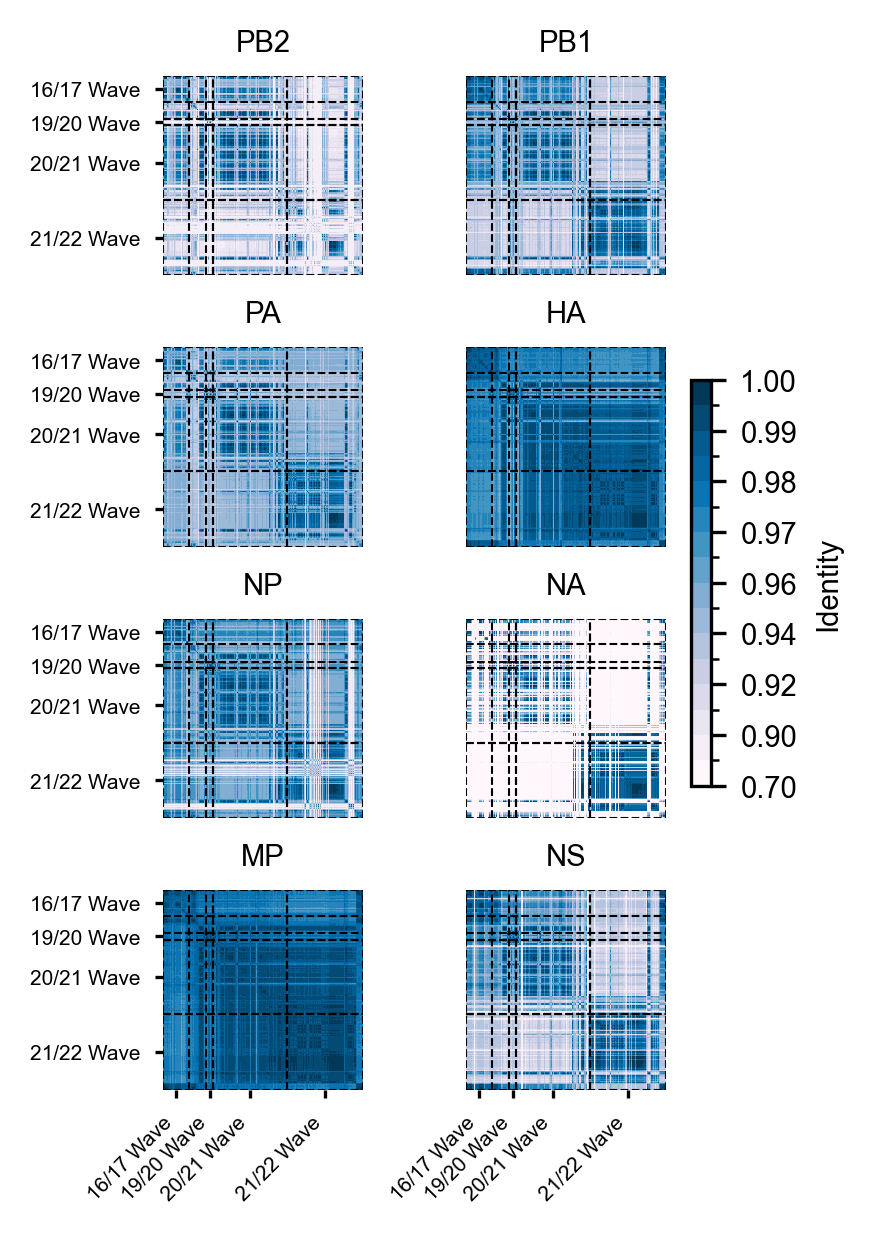

In [342]:
with mpl.rc_context({'font.family': 'Arial', 'font.size': 7, 'hatch.linewidth': .5, 'lines.linewidth': .5, 'patch.linewidth': .5,}):

    fig, axes = plt.subplots(4, 2, figsize=(3, 4), dpi=300, layout='compressed')
    axes = np.ravel(axes)

    bins = [0.7,0.8, 0.9, 0.91,0.92,0.93,0.94, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]
#     bins = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]
    nbin = len(bins) - 1
    cmap = cm.get_cmap('PuBu', nbin)
    norm = mcolors.BoundaryNorm(bins, nbin)

    for i, seg in enumerate(['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']):

        ax = axes[i]

        identity_mat = identity_mat_dict[seg]
        im = ax.imshow(identity_mat, cmap=cmap, norm=norm)

        ax.set_xticks([])
        ax.set_yticks([]) 
        ax.set_title(seg, fontsize=7)

        if i in [0, 2, 4, 6]:
            ax.set_yticks([(w_s1+w_e1)/2, (w_s2+w_e2)/2, (w_s3+w_e3)/2, (w_s4+w_e4)/2])
            ax.set_yticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], rotation=0)
            ax.tick_params(length=2, labelsize=5)
        
        if i in [6, 7]:
            ax.set_xticks([(w_s1+w_e1)/2, (w_s2+w_e2)/2, (w_s3+w_e3)/2, (w_s4+w_e4)/2])
            ax.set_xticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], fontdict={'horizontalalignment':'right', 'verticalalignment': 'top'}, rotation=45)
            ax.tick_params(length=2, labelsize=5)

        for i, bin_i in enumerate([w_s1, w_e1, w_s2, w_e2, w_s3, w_e3, w_s4, w_e4]):
            ax.axvline(x=bin_i, color='black', ls='--', lw=.5)
            ax.axhline(y=bin_i, color='black', ls='--', lw=.5)
            
        [ax.spines[loc].set_visible(False) for loc in ax.spines]

    fig.colorbar(im, ax=axes, shrink=.4, fraction=.15, label='Identity',)
    plt.show()

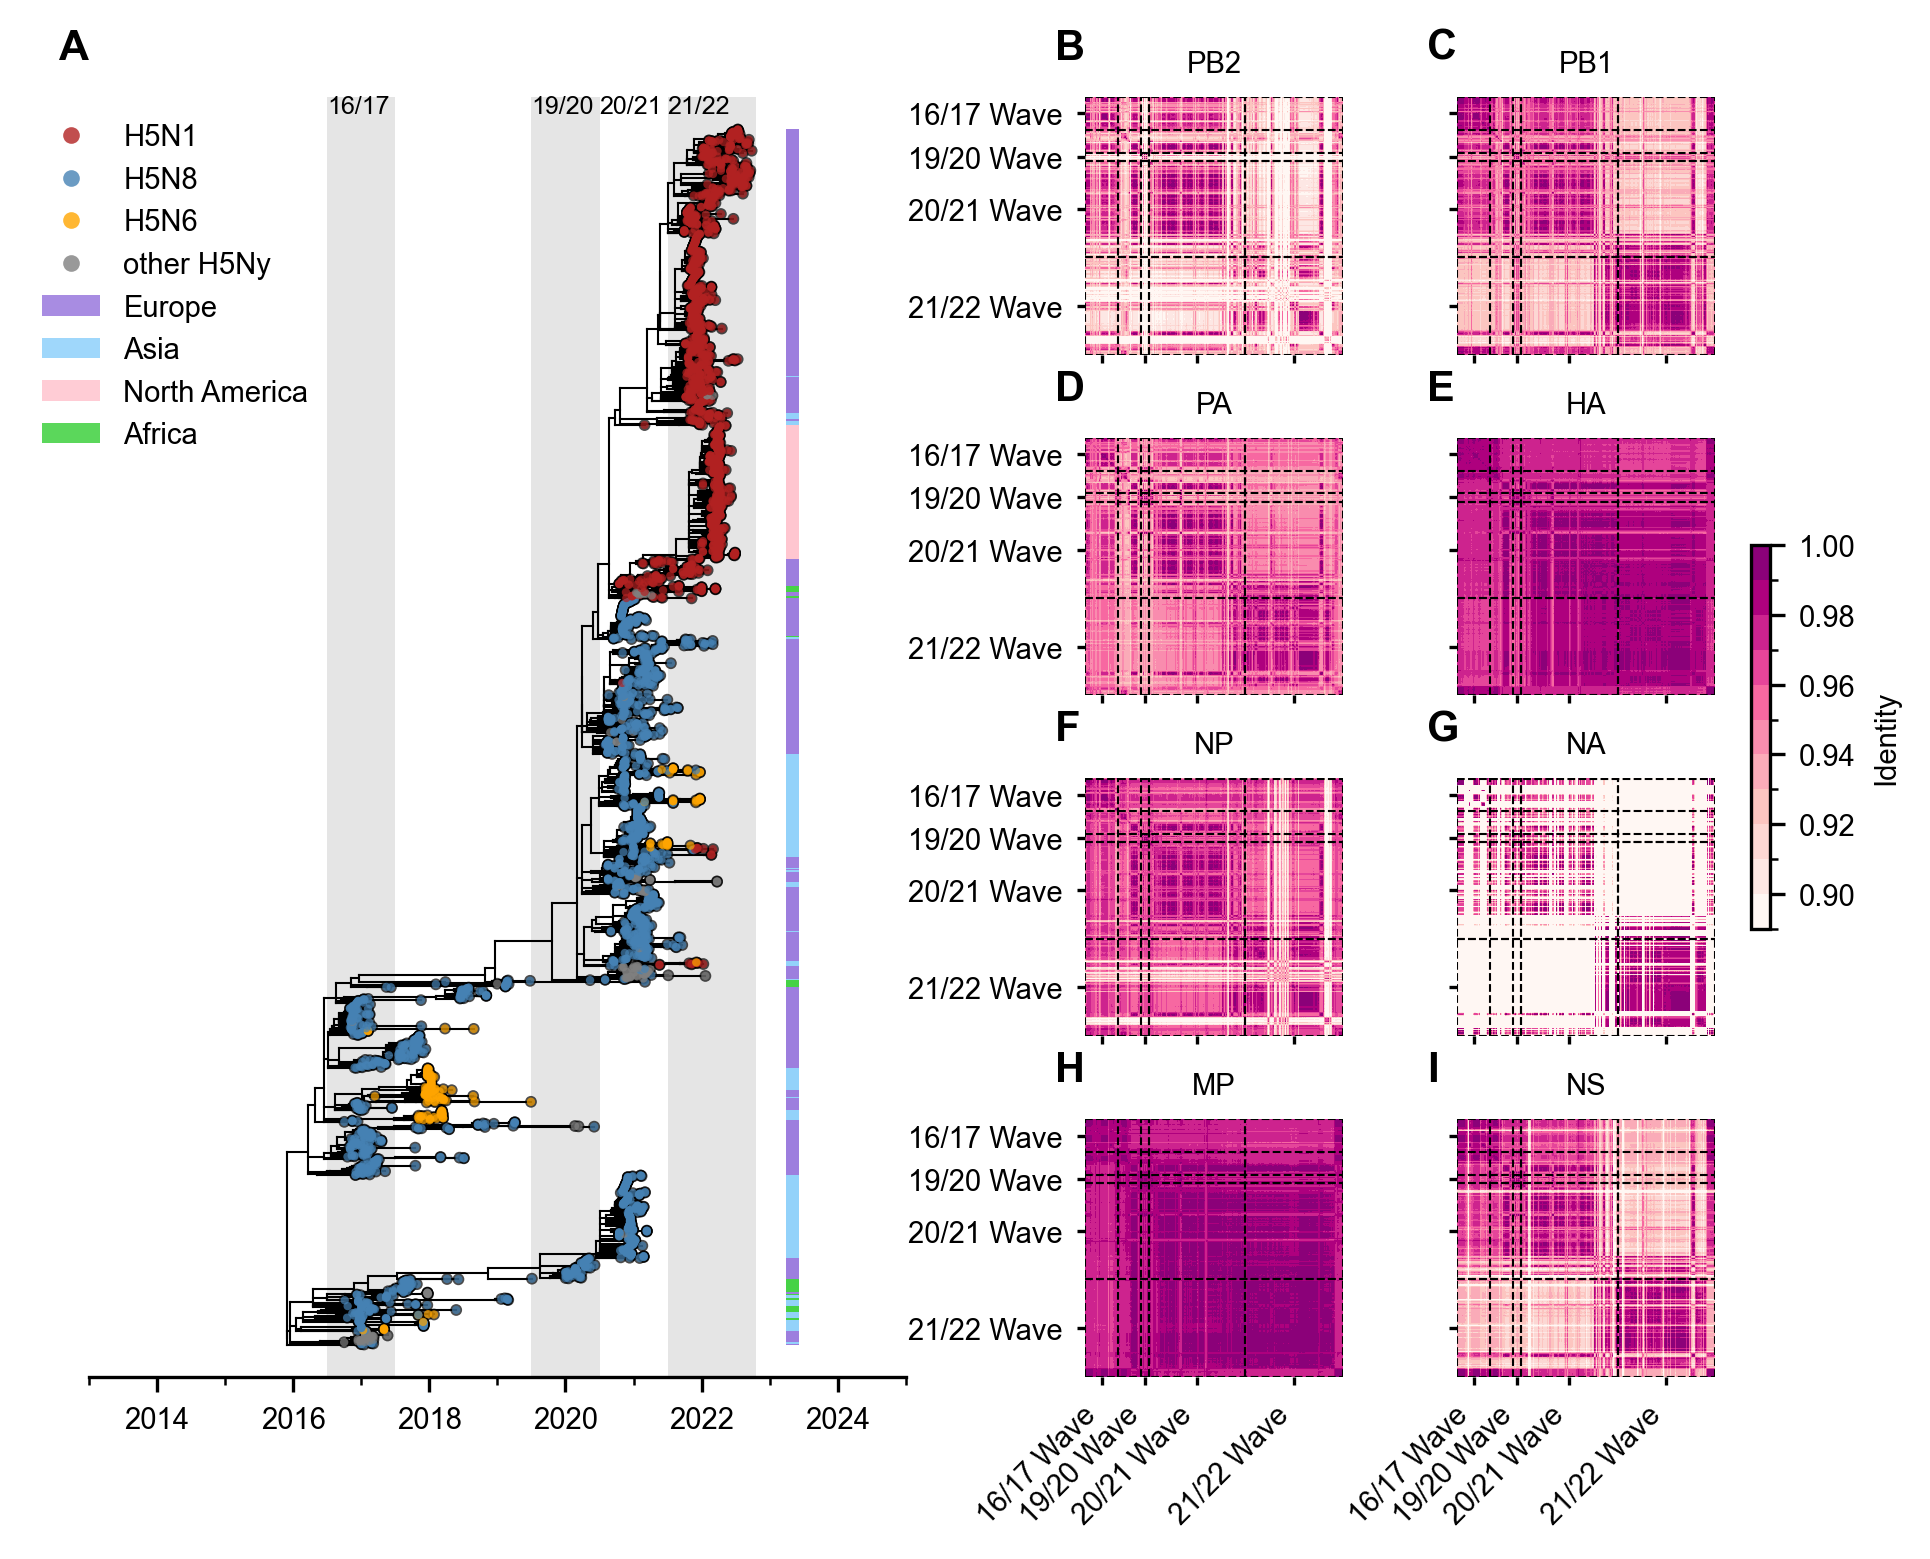

In [390]:
fig = plt.figure(figsize=(7.25, 5), dpi=300, layout='compressed')
# fig = plt.figure(figsize=(4.75, 5), dpi=300, layout='compressed')
spec = fig.add_gridspec(4, 4,  width_ratios=[1.2, 1.2, 1.0, 1.0])

trans = ScaledTranslation(-30/300, 30/300, fig.dpi_scale_trans)
index_ = 'ABCDEFGHIJKLM'

with mpl.rc_context({'font.family': 'Arial', 'font.size': 7, 'hatch.linewidth': .5, 'lines.linewidth': .5, 'patch.linewidth': .5,}):

    ax1 = fig.add_subplot(spec[:, 0:2])
    ax1.text(0.0, 1.0, 'A', transform=ax1.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

    cmap_subtype = {'H5N1': 'firebrick', 'H5N8': 'steelblue', 'H5N6': 'orange'}
    cmap_region = {'Europe': 'mediumpurple', 'Asia': 'lightskyblue',  'North America': 'pink', 'Africa': 'limegreen'}

    treeHeight = ll.treeHeight
    y_attr=lambda k: -k.y
    x_attr=lambda k: k.absoluteTime

    def leaf_color_func(k, cat='region', cmap=cmap_region):
        if not k.branchType == 'leaf':
            return 'k'
        attr = isl2subtype.get(k.name)
        color = cmap.get(attr, 'gray')
        return color


    leaf_color_func = functools.partial(leaf_color_func, cat='subtype', cmap=cmap_subtype)

    ll.plotTree(ax1, x_attr=x_attr, y_attr=y_attr, width=.5)
    ll.plotPoints(ax1, x_attr=x_attr, y_attr=y_attr, colour=leaf_color_func, size=4, zorder=100, alpha=.7)
    
    # plot tip region annotation
    def add_tip_bar_annotation(tre, h=1, w=.2):
        rects = []
        for leaf in tre.getExternal():
            y = leaf.y
            attr = isl2region.get(leaf.name)
            color = cmap_region.get(attr, 'k')
            
            rect = Rectangle((tre.mostRecent+0.5, -y-h/2), w, h, facecolor=color, edgecolor='none', alpha=.9)
            rects.append(rect)
        return rects

    rects = add_tip_bar_annotation(ll)
    for rect in rects:
        ax1.add_patch(rect)
   
    # plot legend
    handles = []
    for k, v in cmap_subtype.items():
        handles.append(Line2D([0], [0], lw=0, marker='o', markeredgecolor='none', markersize=4, markerfacecolor=v, label=k, alpha=.8))
    handles.append(Line2D([0], [0], lw=0, marker='o', markeredgecolor='none', markersize=4, markerfacecolor='gray', label='other H5Ny', alpha=.8))
    for k, v in cmap_region.items():
        handles.append(Patch(facecolor=v, alpha=.8, edgecolor='none', label=k))

    ax1.legend(handles=handles, frameon=False, fontsize=7, loc='upper left', bbox_to_anchor=(-.09, 1))
    
    # modify axis
    # ax1.set_xticks(ticks=np.arange(2014, 2024, 2), minor=True)
    ax1.set(xlim=(2013, 2025), ylim=(-100-ll.ySpan, 100), yticks=[], yticklabels=[])
    ax1.xaxis.set_major_locator(MultipleLocator(2))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    # ax1.set_minor
    ax1.tick_params(axis='x', labelsize=7, rotation=0)

    ax1.axvspan(2016.5, 2017.5, facecolor='k', edgecolor='none', alpha=.1)
    ax1.axvspan(2019.5, 2020.5, facecolor='k', edgecolor='none', alpha=.1)
    ax1.axvspan(2020.5, 2021.5, facecolor='none', edgecolor='none', alpha=.1)
    ax1.axvspan(2021.5, 2022.8, facecolor='k', edgecolor='none', alpha=.1)
    
    ax1.text(2016.5, 50, '16/17', fontdict={'fontsize': 6})
    ax1.text(2019.5, 50, '19/20', fontdict={'fontsize': 6})
    ax1.text(2020.5, 50, '20/21', fontdict={'fontsize': 6})
    ax1.text(2021.5, 50, '21/22', fontdict={'fontsize': 6})

    [ax1.spines[loc].set_visible(False) for loc in ax1.spines if loc!='bottom']

    
    # ************************************************************************************************************************
    # define boundary norm colorbar
    # bins = [0.7,0.8, 0.9, 0.91,0.92,0.93,0.94, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]
    bins = [0, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
    nbin = len(bins) - 1
    cmap = cm.get_cmap('RdPu', nbin+2)
    norm = mcolors.BoundaryNorm(bins, nbin)
    
    heatmap_axes = []
    for i, seg in enumerate(['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']):
        
        ax = fig.add_subplot(spec[i//2, i%2+2]); heatmap_axes.append(ax)
        ax.text(0.0, 1.0, index_[i+1], transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')
        
        identity_mat = identity_mat_dict[seg]
        im = ax.imshow(identity_mat, cmap=cmap, norm=norm)

        ax.set(xticks=[], yticks=[])
        ax.set_title(seg, fontsize=7)


        ax.set_yticks([(w_s1+w_e1)/2, (w_s2+w_e2)/2, (w_s3+w_e3)/2, (w_s4+w_e4)/2], '')
        ax.set_xticks([(w_s1+w_e1)/2, (w_s2+w_e2)/2, (w_s3+w_e3)/2, (w_s4+w_e4)/2], '')

        if i in [0, 2, 4, 6]:
            ax.set_yticklabels(['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], rotation=0)
        
        if i in [6, 7]:
            ax.set_xticklabels(
                ['16/17 Wave', '19/20 Wave', '20/21 Wave', '21/22 Wave'], 
                fontdict={'horizontalalignment':'right', 'verticalalignment': 'top'}, 
                rotation=45
            )
        
        ax.tick_params(axis='both', length=2, labelsize=7)

        for i, bin_i in enumerate([w_s1, w_e1, w_s2, w_e2, w_s3, w_e3, w_s4, w_e4]):
            ax.axvline(x=bin_i, color='black', ls='--', lw=.5)
            ax.axhline(y=bin_i, color='black', ls='--', lw=.5)
            
        [ax.spines[loc].set_visible(False) for loc in ax.spines]
        
    fig.colorbar(im, ax=heatmap_axes, shrink=.3, fraction=.2, label='Identity', ticks=np.arange(0.9, 1.1, 0.02))
    fig.get_layout_engine().set(w_pad=0/300, h_pad=0/300, wspace=0.01, hspace=0.02)
    
    plt.savefig('./results/Fig2.pdf')
    plt.show()